# Introduction

This notebook tackles [**Playground Series – Season 5, Episode 9: Predicting the Beats-per-Minute (BPM) of Songs**](https://www.kaggle.com/competitions/playground-series-s5e9). The goal is to build a robust regression model that maps a set of audio-derived descriptors (e.g., measures of energy, loudness, vocal vs. instrumental content, rhythmic/melodic characteristics, and track duration) to a continuous BPM target. Submissions are evaluated using **Root Mean Squared Error (RMSE)**, so we’ll optimize for low average squared deviations while keeping an eye on outliers that can disproportionately affect the score.

### Why this problem is interesting

*   **Signal ↔ target alignment:** Features such as _Energy_, _AudioLoudness_, _RhythmScore_, and _VocalContent/InstrumentalScore_ are plausible physical/musical correlates of tempo, so we expect meaningful structure rather than pure noise.
*   **Real-world wrinkles:** Music contains broad BPM ranges (slow ballads to high-tempo EDM), mixed production styles, and potential edge cases (very short/long tracks), all of which can create **heteroskedasticity** and **non-linear** relationships.
*   **Modeling tradeoffs:** Simpler linear models provide transparency; tree/boosting models capture interactions and non-linearities; ensembling can blend the best of both.
    

### Plan of attack

1. **Data audit & cleaning**
   - Confirm shapes, dtypes, missingness, and constant/near-constant columns.
   - Remove non-informative identifiers (e.g., id) from training features.
   - Detect extreme values (e.g., unusually long TrackDurationMs or extreme AudioLoudness) and decide whether to cap, transform, or leave as-is.
2. **Exploratory analysis**
   - Inspect **BPM distribution** and check for multi-modality.
   - Visualize **feature distributions** and **pairwise relationships** (hexbin for dense scatter).
   - Quantify **correlations** (Pearson/Spearman) and highlight top pairs/feature↔target links.
3. **Baseline → stronger models**
   - Baseline: mean/median; then Ridge/Lasso/ElasticNet with sensible scaling.
   - Tree-based: RandomForest / XGBoost / LightGBM / CatBoost with careful CV and early stopping.
   - Optional feature engineering: simple interactions (e.g., Energy \* RhythmScore), monotonic transforms (e.g., log of duration), and polynomial terms where justified.
4. **Validation & reliability**
   - **K-Fold CV** (e.g., 5 folds) on the training set for honest performance estimates.
   - Track both **CV RMSE** and **OOF residual diagnostics** (error vs. predicted BPM, vs. duration, etc.).
   - Maintain **reproducibility**: fixed random\_state, version-locked libraries, and a clean preprocessing pipeline that mirrors test-time steps.
5. **Submission & iteration**
   - Generate predictions for test.csv, assemble the submission file, and iterate based on CV diagnostics and leaderboard feedback.

# Table of Contents

1. [Introduction](#Introduction)  
2. [Data Loading and Overview](#Data-Loading-and-Overview)
3. [Data Visualization](#Data-Visualization)
4. [Examine Original Dataset](#Examine-Original-Dataset)
5. [Dataset Comparison Report](#Dataset-Comparison-Report)
6. [Feature Engineering](#Feature-Engineering)
7. [Prepare Submission](#Prepare-Submission)


# Data Loading and Overview

In [1]:
%pip install --no-binary lightgbm --config-settings=cmake.define.USE_CUDA=ON lightgbm


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip -q install -U optuna
%pip -q install optuna-integration[lightgbm]


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# --- Standard library
import os
import sys
import random
import warnings
from pathlib import Path
from contextlib import contextmanager
from time import time

# --- Third-party
import numpy as np
import pandas as pd
import optuna
from optuna.samplers import TPESampler
from optuna.visualization.matplotlib import (
    plot_optimization_history,
    plot_param_importances,
    plot_parallel_coordinate,
    plot_slice,
    plot_edf,
)
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from pandas.api.types import (
    is_categorical_dtype,
    is_numeric_dtype,
    is_object_dtype,
)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer, StandardScaler, RobustScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score, RandomizedSearchCV
from sklearn import set_config
set_config(transform_output="pandas")
from statsmodels.graphics.gofplots import qqplot
from tqdm import tqdm
import lightgbm as lgbm
import xgboost as xgb

# --- Notebook settings
warnings.filterwarnings("ignore")

# Suppress XGBoost warnings about mismatched devices and tree methods.
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost.core')

%matplotlib inline

In [4]:
# Define some utilities functions
def configure_notebook(seed: int = 10301, float_precision: int = 3, max_columns: int = 15, max_rows: int = 25) -> int:
    """
    Configure notebook settings:
      - Disables warnings for cleaner output.
      - Sets pandas display options for better table formatting.
      - Returns a seed value for reproducibility.
    
    Parameters:
      seed (int): Random seed (default 548).
      float_precision (int): Number of decimal places for floats (default 3).
      max_columns (int): Maximum number of columns to display (default 15).
      max_rows (int): Maximum number of rows to display (default 25).

    Returns:
      int: The provided seed.
    """
    # Disable all warnings
    warnings.filterwarnings("ignore")
    
    # Set pandas display options for nicer output
    pd.options.display.float_format = f"{{:,.{float_precision}f}}".format
    pd.set_option("display.max_columns", max_columns)
    pd.set_option("display.max_rows", max_rows)

    # Set seeds for reproducibility in numpy and the standard random module
    np.random.seed(seed)
    random.seed(seed)
    
    return seed

def running_in_kaggle() -> bool:
    """
    Heuristics that are true in Kaggle notebooks:
    - Special directories exist (/kaggle/input, /kaggle/working)
    - Env var KAGGLE_KERNEL_RUN_TYPE is set
    - The kaggle_secrets module is available
    """
    try:
        if os.path.isdir("/kaggle/input") and os.path.isdir("/kaggle/working"):
            return True
        if "KAGGLE_KERNEL_RUN_TYPE" in os.environ:
            return True
        import kaggle_secrets  # noqa: F401  (only exists in Kaggle)
        return True
    except Exception:
        return False

# Use a context manager to suppress standard error output
# This is a robust way to handle warnings that bypass Python's warnings module
class SuppressStderr:
    def __enter__(self):
        self.original_stderr = sys.stderr
        sys.stderr = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stderr.close()
        sys.stderr = self.original_stderr

In [5]:
# Apply configuration and set random seeds for reproducibility
seed = configure_notebook()    

In [6]:
# Configurable flag to control whether GPU is used
USE_GPU = True

def resolve_lgbm_device(use_gpu: bool, X: pd.DataFrame, y: pd.Series,
                        platform_id: int = -1, device_id: int = -1):
    """
    Returns a dict of LightGBM params for the chosen device.
    Tries OpenCL GPU -> CPU.
    """
    if not use_gpu:
        return {"device_type": "cpu", "force_col_wise": True}  # CPU-only hint

    try:
        probe = lgbm.LGBMRegressor(
            n_estimators=10,
            device_type="gpu",
            max_bin=63,
            gpu_platform_id=platform_id, 
            gpu_device_id=device_id,
            verbosity=-1,
        )
        # tiny probe fit to validate the backend works
        _n = min(len(X), 2000)
        probe.fit(X.iloc[:_n], y.iloc[:_n])
        return {"device_type": "gpu", "gpu_platform_id": platform_id, "gpu_device_id": device_id}
    except Exception as e:
        print("OpenCL not available, falling back to CPU:", type(e).__name__, e)

    # Fall back to CPU
    return {"device_type": "cpu", "force_col_wise": True}

In [7]:
def eda_summary(df: pd.DataFrame) -> None:
    """
    Produce a concise, notebook-friendly Exploratory Data Analysis (EDA) summary.

    This utility prints and displays a standard set of diagnostics for a single
    DataFrame to help you quickly understand schema, completeness, and basic
    statistics. It is designed for use in Jupyter/IPython environments.

    The report includes:
      1. **First 5 rows** (transposed for vertical readability).
      2. **DataFrame info** (`df.info()`): dtypes and non-null counts.
      3. **Numeric describe** (`df.describe()`): count/mean/std/min/percentiles/max.
      4. **Categorical describe** (`df.select_dtypes(['object','category']).describe()`),
         or a note if none exist.
      5. **Missing values summary**: a table with per-column missing count and
         percentage of total rows.
      6. **Duplicate rows**: total number of duplicated records (`df.duplicated().sum()`).
      7. **Data types count**: frequency of each dtype in `df.dtypes`.
      8. **Correlation matrix** for numeric columns (if more than one numeric
         column exists), computed with Pearson correlation.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame to summarize.

    Returns
    -------
    None
        Displays/prints the EDA sections and returns nothing.
    """
    # 1. Display the first few rows
    print("======== First 5 Rows ========")
    display(df.head().T)
    
    # 2. DataFrame information (data types, non-null counts, etc.)
    print("\n======== DataFrame Info ========")
    df.info()
    
    # 3. Descriptive statistics for numeric columns
    print("\n======== Descriptive Statistics (Numeric Columns) ========")
    display(df.describe().T)
    
    # 4. Descriptive statistics for categorical columns (if any)
    categorical_df = df.select_dtypes(include=['object', 'category'])
    print("\n======== Descriptive Statistics (Categorical Columns) ========")
    if not categorical_df.empty:
        display(categorical_df.describe())
    else:
        print("No categorical columns found.")
    
    # 5. Missing values summary
    print("\n======== Missing Values Summary ========")
    missing = df.isnull().sum()
    missing_percent = (missing / len(df)) * 100
    missing_summary = pd.DataFrame({
        "Missing Count": missing,
        "Percentage": missing_percent
    })
    display(missing_summary)
    
    # 6. Count of duplicated rows
    print("\n======== Duplicated Rows ========")
    print(f"Total duplicated rows: {df.duplicated().sum()}")
    
    # 7. Count of each data type
    print("\n======== Data Types Count ========")
    display(df.dtypes.value_counts())
    
    # 8. Correlation matrix for numeric variables (if more than one exists)
    numeric_cols = df.select_dtypes(include=[np.number])
    if numeric_cols.shape[1] > 1:
        print("\n======== Correlation Matrix (Numeric Columns) ========")
        display(numeric_cols.corr())
    else:
        print("\n======== Correlation Matrix ========")
        print("Not enough numeric columns to compute correlation.")
    
    # 9. Value counts for categorical variables with low cardinality
    print("\n======== Value Counts for Categorical Columns (Low Cardinality) ========")
    if not categorical_df.empty:
        for col in categorical_df.columns:
            if df[col].nunique() <= 20:
                print(f"\nValue Counts for '{col}':")
                display(df[col].value_counts())
    else:
        print("No categorical columns found.")


#### Read the training data and display a bit of it

In [8]:
DATA_DIR = Path('/kaggle/input/playground-series-s5e9') if running_in_kaggle() else Path('data')

training_df = pd.read_csv(DATA_DIR / 'train.csv')
training_df.head()

,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
0,0,0.604,-7.637,0.024,0.000,0.000,0.051,0.410,"290,715.645",0.826,147.530
1,1,0.639,-16.268,0.072,0.445,0.349,0.171,0.651,"164,519.517",0.145,136.160
2,2,0.515,-15.954,0.111,0.174,0.454,0.030,0.424,"174,495.567",0.625,55.320
3,3,0.734,-1.357,0.053,0.002,0.160,0.086,0.279,"225,567.465",0.487,147.912
4,4,0.533,-13.056,0.024,0.069,0.000,0.331,0.478,"213,960.679",0.947,89.585


#### Read the test data and display it

In [9]:
test_df = pd.read_csv(DATA_DIR / 'test.csv')
test_df.head()

,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy
0,524164,0.410,-16.795,0.024,0.233,0.013,0.272,0.664,"302,901.550",0.425
1,524165,0.463,-1.357,0.142,0.058,0.258,0.098,0.830,"221,995.664",0.846
2,524166,0.687,-3.369,0.168,0.288,0.211,0.326,0.305,"357,724.013",0.134
3,524167,0.886,-5.598,0.118,0.000,0.377,0.134,0.488,"271,790.399",0.316
4,524168,0.637,-7.068,0.126,0.539,0.069,0.024,0.591,"277,728.538",0.481


#### The track duration might be comma formatted.  Get rid of them, if present

In [10]:
def coerce_numeric(df, cols) -> None:
    """
    Convert selected columns to numeric dtype in-place, coercing invalid values to NaN.

    For each column name in ``cols`` that exists in ``df``, this function:
    1) casts the column to string,
    2) removes thousands separators (commas),
    3) applies ``pd.to_numeric(..., errors="coerce")``.

    Any value that cannot be parsed as a number becomes ``NaN``. Columns listed
    in ``cols`` but not present in ``df`` are silently skipped.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame whose columns will be normalized.
    cols : Iterable[str]
        Column names to coerce to numeric.

    Returns
    -------
    None
        The function mutates ``df`` in-place and returns nothing.
    """
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c].astype(str).str.replace(",", ""), errors="coerce")

coerce_numeric(training_df, ["TrackDurationMs"])
coerce_numeric(test_df, ["TrackDurationMs"])

#### Get rid of the 'id' column before examining the data.  Also, it'll confuse training.

In [11]:
training_df.drop('id', axis=1, inplace=True)
training_df.head()

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
0,0.604,-7.637,0.024,0.000,0.000,0.051,0.410,"290,715.645",0.826,147.530
1,0.639,-16.268,0.072,0.445,0.349,0.171,0.651,"164,519.517",0.145,136.160
2,0.515,-15.954,0.111,0.174,0.454,0.030,0.424,"174,495.567",0.625,55.320
3,0.734,-1.357,0.053,0.002,0.160,0.086,0.279,"225,567.465",0.487,147.912
4,0.533,-13.056,0.024,0.069,0.000,0.331,0.478,"213,960.679",0.947,89.585


In [12]:
# Save a copy with the ID for use later
test_ids = test_df['id'].copy()

test_df.drop('id', axis=1, inplace=True)
test_df.head()

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy
0,0.410,-16.795,0.024,0.233,0.013,0.272,0.664,"302,901.550",0.425
1,0.463,-1.357,0.142,0.058,0.258,0.098,0.830,"221,995.664",0.846
2,0.687,-3.369,0.168,0.288,0.211,0.326,0.305,"357,724.013",0.134
3,0.886,-5.598,0.118,0.000,0.377,0.134,0.488,"271,790.399",0.316
4,0.637,-7.068,0.126,0.539,0.069,0.024,0.591,"277,728.538",0.481


## Exploratory Data Analysis

In [13]:
eda_summary(training_df)

======== First 5 Rows ========


,0,1,2,3,4
RhythmScore,0.604,0.639,0.515,0.734,0.533
AudioLoudness,-7.637,-16.268,-15.954,-1.357,-13.056
VocalContent,0.024,0.072,0.111,0.053,0.024
AcousticQuality,0.000,0.445,0.174,0.002,0.069
InstrumentalScore,0.000,0.349,0.454,0.160,0.000
LivePerformanceLikelihood,0.051,0.171,0.030,0.086,0.331
MoodScore,0.410,0.651,0.424,0.279,0.478
TrackDurationMs,"290,715.645","164,519.517","174,495.567","225,567.465","213,960.679"
Energy,0.826,0.145,0.625,0.487,0.947
BeatsPerMinute,147.530,136.160,55.320,147.912,89.585



======== DataFrame Info ========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524164 entries, 0 to 524163
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   RhythmScore                524164 non-null  float64
 1   AudioLoudness              524164 non-null  float64
 2   VocalContent               524164 non-null  float64
 3   AcousticQuality            524164 non-null  float64
 4   InstrumentalScore          524164 non-null  float64
 5   LivePerformanceLikelihood  524164 non-null  float64
 6   MoodScore                  524164 non-null  float64
 7   TrackDurationMs            524164 non-null  float64
 8   Energy                     524164 non-null  float64
 9   BeatsPerMinute             524164 non-null  float64
dtypes: float64(10)
memory usage: 40.0 MB

======== Descriptive Statistics (Numeric Columns) ========


,count,mean,std,min,25%,50%,75%,max
RhythmScore,"524,164.000",0.633,0.157,0.077,0.516,0.635,0.739,0.975
AudioLoudness,"524,164.000",-8.379,4.616,-27.510,-11.552,-8.252,-4.912,-1.357
VocalContent,"524,164.000",0.074,0.050,0.024,0.024,0.066,0.107,0.256
AcousticQuality,"524,164.000",0.263,0.223,0.000,0.069,0.243,0.397,0.995
InstrumentalScore,"524,164.000",0.118,0.132,0.000,0.000,0.074,0.204,0.869
LivePerformanceLikelihood,"524,164.000",0.178,0.118,0.024,0.078,0.166,0.269,0.600
MoodScore,"524,164.000",0.556,0.225,0.026,0.404,0.565,0.717,0.978
TrackDurationMs,"524,164.000","241,903.693","59,326.602","63,973.000","207,099.877","243,684.058","281,851.659","464,723.228"
Energy,"524,164.000",0.501,0.290,0.000,0.255,0.512,0.746,1.000
BeatsPerMinute,"524,164.000",119.035,26.468,46.718,101.070,118.748,136.687,206.037



======== Descriptive Statistics (Categorical Columns) ========
No categorical columns found.

======== Missing Values Summary ========


,Missing Count,Percentage
RhythmScore,0,0.000
AudioLoudness,0,0.000
VocalContent,0,0.000
AcousticQuality,0,0.000
InstrumentalScore,0,0.000
LivePerformanceLikelihood,0,0.000
MoodScore,0,0.000
TrackDurationMs,0,0.000
Energy,0,0.000
BeatsPerMinute,0,0.000



======== Duplicated Rows ========
Total duplicated rows: 0

======== Data Types Count ========


float64    10
Name: count, dtype: int64


======== Correlation Matrix (Numeric Columns) ========


,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
RhythmScore,1.000,-0.017,0.009,0.028,0.011,0.032,-0.009,-0.018,-0.147,0.005
AudioLoudness,-0.017,1.000,-0.009,-0.013,0.004,-0.022,-0.027,0.005,0.192,-0.003
VocalContent,0.009,-0.009,1.000,0.009,-0.018,-0.120,0.059,0.018,0.016,0.005
AcousticQuality,0.028,-0.013,0.009,1.000,0.003,0.010,0.037,-0.023,-0.418,-0.001
InstrumentalScore,0.011,0.004,-0.018,0.003,1.000,-0.002,0.005,0.009,-0.020,0.002
LivePerformanceLikelihood,0.032,-0.022,-0.120,0.010,-0.002,1.000,0.015,0.005,-0.266,0.003
MoodScore,-0.009,-0.027,0.059,0.037,0.005,0.015,1.000,-0.015,-0.242,0.007
TrackDurationMs,-0.018,0.005,0.018,-0.023,0.009,0.005,-0.015,1.000,0.049,0.007
Energy,-0.147,0.192,0.016,-0.418,-0.020,-0.266,-0.242,0.049,1.000,-0.004
BeatsPerMinute,0.005,-0.003,0.005,-0.001,0.002,0.003,0.007,0.007,-0.004,1.000



======== Value Counts for Categorical Columns (Low Cardinality) ========
No categorical columns found.


#### Show the statistics and structure of the test data

In [14]:
eda_summary(test_df)

======== First 5 Rows ========


,0,1,2,3,4
RhythmScore,0.410,0.463,0.687,0.886,0.637
AudioLoudness,-16.795,-1.357,-3.369,-5.598,-7.068
VocalContent,0.024,0.142,0.168,0.118,0.126
AcousticQuality,0.233,0.058,0.288,0.000,0.539
InstrumentalScore,0.013,0.258,0.211,0.377,0.069
LivePerformanceLikelihood,0.272,0.098,0.326,0.134,0.024
MoodScore,0.664,0.830,0.305,0.488,0.591
TrackDurationMs,"302,901.550","221,995.664","357,724.013","271,790.399","277,728.538"
Energy,0.425,0.846,0.134,0.316,0.481



======== DataFrame Info ========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174722 entries, 0 to 174721
Data columns (total 9 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   RhythmScore                174722 non-null  float64
 1   AudioLoudness              174722 non-null  float64
 2   VocalContent               174722 non-null  float64
 3   AcousticQuality            174722 non-null  float64
 4   InstrumentalScore          174722 non-null  float64
 5   LivePerformanceLikelihood  174722 non-null  float64
 6   MoodScore                  174722 non-null  float64
 7   TrackDurationMs            174722 non-null  float64
 8   Energy                     174722 non-null  float64
dtypes: float64(9)
memory usage: 12.0 MB

======== Descriptive Statistics (Numeric Columns) ========


,count,mean,std,min,25%,50%,75%,max
RhythmScore,"174,722.000",0.633,0.157,0.141,0.515,0.635,0.739,0.975
AudioLoudness,"174,722.000",-8.377,4.622,-27.443,-11.550,-8.253,-4.904,-1.357
VocalContent,"174,722.000",0.074,0.050,0.024,0.024,0.066,0.107,0.259
AcousticQuality,"174,722.000",0.263,0.223,0.000,0.069,0.242,0.397,0.995
InstrumentalScore,"174,722.000",0.117,0.132,0.000,0.000,0.074,0.203,0.681
LivePerformanceLikelihood,"174,722.000",0.178,0.118,0.024,0.078,0.166,0.268,0.600
MoodScore,"174,722.000",0.556,0.226,0.026,0.404,0.566,0.717,0.978
TrackDurationMs,"174,722.000","241,753.736","59,103.897","63,973.000","207,518.151","243,584.585","281,737.445","449,288.808"
Energy,"174,722.000",0.501,0.291,0.000,0.254,0.512,0.746,1.000



======== Descriptive Statistics (Categorical Columns) ========
No categorical columns found.

======== Missing Values Summary ========


,Missing Count,Percentage
RhythmScore,0,0.000
AudioLoudness,0,0.000
VocalContent,0,0.000
AcousticQuality,0,0.000
InstrumentalScore,0,0.000
LivePerformanceLikelihood,0,0.000
MoodScore,0,0.000
TrackDurationMs,0,0.000
Energy,0,0.000



======== Duplicated Rows ========
Total duplicated rows: 0

======== Data Types Count ========


float64    9
Name: count, dtype: int64


======== Correlation Matrix (Numeric Columns) ========


,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy
RhythmScore,1.000,-0.019,0.008,0.035,0.004,0.033,-0.010,-0.021,-0.151
AudioLoudness,-0.019,1.000,-0.010,-0.015,0.010,-0.019,-0.027,0.006,0.189
VocalContent,0.008,-0.010,1.000,0.009,-0.016,-0.119,0.060,0.021,0.020
AcousticQuality,0.035,-0.015,0.009,1.000,0.004,0.018,0.034,-0.017,-0.423
InstrumentalScore,0.004,0.010,-0.016,0.004,1.000,-0.003,0.005,0.009,-0.020
LivePerformanceLikelihood,0.033,-0.019,-0.119,0.018,-0.003,1.000,0.017,0.005,-0.269
MoodScore,-0.010,-0.027,0.060,0.034,0.005,0.017,1.000,-0.017,-0.240
TrackDurationMs,-0.021,0.006,0.021,-0.017,0.009,0.005,-0.017,1.000,0.045
Energy,-0.151,0.189,0.020,-0.423,-0.020,-0.269,-0.240,0.045,1.000



======== Value Counts for Categorical Columns (Low Cardinality) ========
No categorical columns found.


# Data Visualization

#### Target & Feature distributions — What & why
We first examine the distribution of **BeatsPerMinute** and the marginal distributions of key numeric features.
This reveals central tendency, spread, skewness, and potential multi‑modality (e.g., half/double‑time clusters).
These insights inform scaling and simple transforms (e.g., `log1p(TrackDurationMs)`) and guard against outlier‑driven RMSE errors.

In [15]:
def detect_target(df: pd.DataFrame):
    """
    Infer the target column name from common candidates.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame to inspect.

    Returns
    -------
    str
        The name of the detected target column.

    Raises
    ------
    KeyError
        If none of the candidate names are present in ``df`` columns.
    """
    candidates = ["BPM", "bpm", "tempo", "Tempo", "target", "BeatsPerMinute"]
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError("Could not detect target column. Set `target_col` manually.")

def numeric_features(df: pd.DataFrame, exclude=None) -> list[str]:
    """
    Return numeric feature column names, optionally excluding some.

    Uses ``DataFrame.select_dtypes(include="number")`` to find numeric dtypes
    (e.g., int, float; typically excludes booleans), then removes any names
    provided in ``exclude``.

    Parameters
    ----------
    df : pandas.DataFrame
        Source DataFrame.
    exclude : iterable of str or None, optional
        Column names to exclude from the result. Defaults to ``None``.

    Returns
    -------
    list of str
        Ordered list of numeric feature column names present in ``df`` and
        not listed in ``exclude``.
    """
    exclude = set(exclude or [])
    return [c for c in df.select_dtypes(include="number").columns if c not in exclude]

def safe_sample(df: pd.DataFrame, n: int = 200_000, seed: int = seed) -> pd.DataFrame:
    """
    Return a sample of up to ``n`` rows without replacement; if ``df`` has
    ``<= n`` rows, return it unchanged.

    This is a convenience helper for large datasets—useful to keep quick EDA
    cells responsive while remaining deterministic via ``seed``.

    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame.
    n : int, optional
        Maximum number of rows to return. Default is ``200_000``.
    seed : int, optional
        Random seed for reproducibility (passed to ``random_state``). Default ``seed``.

    Returns
    -------
    pandas.DataFrame
        A sampled view of ``df`` with at most ``n`` rows, or ``df`` itself if
        it already has ``<= n`` rows.
    """
    if len(df) > n:
        return df.sample(n, random_state=seed)
    return df

def describe_df(df: pd.DataFrame):
    """
    Summarize a modeling DataFrame as (target, numeric_features).

    Detects the target column via :func:`detect_target`, then returns the target
    name and the list of numeric feature columns excluding that target.

    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame expected to contain a recognizable target column.

    Returns
    -------
    (str, list of str)
        A 2-tuple ``(target_name, numeric_feature_names)``.

    Raises
    ------
    KeyError
        Propagated from :func:`detect_target` if no target column is found.
    """
    target = detect_target(df)
    nums   = numeric_features(df, exclude=[target])
    return target, nums

In [16]:
def plot_target_distribution(df: pd.DataFrame, target:str) :
    """
    Plot a histogram of a target column in a DataFrame.

    Computes the number of bins as ``max(20, floor(sqrt(N)))`` where ``N`` is the
    number of rows, then renders a simple histogram using Matplotlib. The plot is
    titled with the target name and labeled on both axes.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing the target column.
    target : str
        Name of the target column in ``df``.

    Returns
    -------
    None
        Displays the histogram and returns nothing.

    Raises
    ------
    KeyError
        If ``target`` is not a column in ``df``.
    """
    plt.figure(figsize=(8,5))
    x = df[target].to_numpy()
    bins = max(20, int(np.sqrt(len(x))))
    plt.hist(x, bins=bins, edgecolor="black")
    plt.title(f"{target} Distribution")
    plt.xlabel(target)
    plt.ylabel("Count")
    plt.show()

In [17]:
def plot_feature_distributions(df: pd.DataFrame, num: list[str]) :
    """
    Plot histograms for a prioritized subset of numeric features.

    Given a list of candidate numeric columns, the function selects features
    using a case-insensitive priority list:
    {"energy", "audioloudness", "vocalscore", "vocalcontent", "instrumentalscore",
     "rhythmscore", "acousticquality", "moodscore", "trackdurationms"}.
    If none of the provided names match the priority set, it falls back to the
    first eight names in ``num``.

    For each selected feature, missing values are dropped, an appropriate number
    of bins is chosen as ``max(20, floor(sqrt(N)))``, and a histogram is rendered
    with axis labels and a title.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing the candidate feature columns.
    num : list of str
        Names of numeric columns to consider. The function will plot up to eight
        of these, prioritizing the canonical feature names listed above.

    Returns
    -------
    None
        Displays one histogram per selected feature and returns nothing.

    Raises
    ------
    KeyError
        If any selected column name is not present in ``df``.
    TypeError
        If a selected column is non-numeric and cannot be histogrammed.
    """
    priority = {
        "energy", "audioloudness", "vocalscore", "vocalcontent", "instrumentalscore",
        "rhythmscore", "acousticquality", "moodscore", "trackdurationms"
    }
    
    top_view = [c for c in num if c.lower() in priority]
    if not top_view:
        top_view = num[:8]  # fallback

    for col in top_view:
        vals = df[col].dropna().to_numpy()
        if len(vals) == 0:
            continue
            
        plt.figure(figsize=(8,4))
        bins = max(20, int(np.sqrt(len(vals))))
        plt.hist(vals, bins=bins, edgecolor="black")
        plt.title(f"{col} Distribution")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.show()

In [18]:
def plot_feature_target_relationships(df: pd.DataFrame, target:str, num: list[str]):
    """
    Plot hexbin relationships between selected features and the target.

    The function first subsamples up to 200,000 rows (via ``safe_sample``) from
    the columns ``[target] + num`` for responsiveness. It then checks a
    canonical, case-sensitive list of feature→target pairs:

        ("AudioLoudness", target),
        ("Energy", target),
        ("VocalContent", target),
        ("InstrumentalScore", target),
        ("RhythmScore", target),
        ("TrackDurationMs", target)

    Any pair whose columns are present in the sampled DataFrame is plotted as a
    hexbin density scatter with a count colorbar.

    Parameters
    ----------
    df : pandas.DataFrame
        Source DataFrame containing the target and candidate feature columns.
    target : str
        Name of the target column in ``df`` (must be numeric for hexbin).
    num : list of str
        Candidate numeric feature column names. Used to subset the DataFrame
        before plotting (for performance) and to ensure the target is present.

    Returns
    -------
    None
        Displays one hexbin plot per valid (feature, target) pair and returns nothing.

    Raises
    ------
    KeyError
        If any of the columns in ``[target] + num`` are not present in ``df``.
    TypeError or ValueError
        If a plotted column contains non-numeric data incompatible with hexbin.
    """
    sampled = safe_sample(df[[target] + num], n=200_000)

    pairs_to_check = [
        ("AudioLoudness", target),
        ("Energy", target),
        ("VocalContent", target),
        ("InstrumentalScore", target),
        ("RhythmScore", target),
        ("TrackDurationMs", target),
    ]
    pairs_to_check = [(x,y) for x,y in pairs_to_check if x in sampled.columns and y in sampled.columns]

    for x, y in pairs_to_check:
        plt.figure(figsize=(7,6))
        hb = plt.hexbin(sampled[x], sampled[y], gridsize=40, mincnt=1)
        plt.xlabel(x); plt.ylabel(y); plt.title(f"{x} vs. {y} (hexbin)")
        cb = plt.colorbar(hb); cb.set_label("count")
        plt.show()

In [19]:
def plot_missing_values(df: pd.DataFrame):
    """
    Visualize the count of missing values per column as a horizontal bar chart.

    Computes per-column NA counts, filters out columns with zero missing values,
    and plots a horizontal bar chart sorted by descending count. If the DataFrame
    has no missing values, a message is printed instead of plotting.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame to analyze for missing values.

    Returns
    -------
    None
        Displays the plot (if any) and returns nothing.
    """
    na_counts = df.isna().sum().sort_values(ascending=False)
    na_counts = na_counts[na_counts > 0]
    if len(na_counts):
        plt.figure(figsize=(8, max(3, len(na_counts)*0.35)))
        plt.barh(na_counts.index.astype(str), na_counts.values)
        plt.title("Missing Values per Column")
        plt.xlabel("Count")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.show()
    else:
        print("No missing values detected.")

In [20]:
# Show top non-trivial pairs
def top_pairs(corr: pd.Series, k: int = 10):
    """
    Return the top-k strongest (absolute) pairwise correlations from an unstacked correlation Series.

    Expects a Series whose index is a 2-level MultiIndex ``(col_i, col_j)`` and whose
    values are correlation coefficients (usually absolute values), e.g. produced by
    ``df.corr().abs().unstack()``. Self-pairs and symmetric duplicates are removed
    by keeping only entries where ``col_i < col_j``.

    Parameters
    ----------
    corr : pandas.Series
        Series with MultiIndex pairs and correlation values.
    k : int, optional
        Number of top pairs to return. Default is ``10``.

    Returns
    -------
    list of (Hashable, Hashable, float)
        A list of ``(col_i, col_j, value)`` tuples sorted by descending ``value``,
        containing only non-trivial, unique pairs.
    """
    pairs = [(a,b,v) for (a,b),v in corr.items() if a<b]
    return sorted(pairs, key=lambda x: x[2], reverse=True)[:k]

def show_relationship_rank(df: pd.DataFrame):
    """
    Compute and return the strongest pairwise relationships among numeric columns
    using both Pearson (linear) and Spearman (rank/monotonic) correlations.

    The function:
      1) Selects numeric columns via ``df.select_dtypes(include="number")``.
      2) Computes absolute-valued Pearson and Spearman correlation matrices.
      3) Unstacks each matrix to a long Series of ``(col_i, col_j) -> score``.
      4) Summarizes with ``top_pairs(...)`` to keep only unique, non-trivial
         pairs (no self-pairs, no symmetric duplicates) sorted by descending score.
         By default, ``top_pairs`` returns the top 10 pairs for each metric.

    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame containing candidate numeric features.

    Returns
    -------
    Tuple[List[Tuple[Hashable, Hashable, float]], List[Tuple[Hashable, Hashable, float]]]
        ``(pearson_top, spearman_top)`` where each element is a list of
        ``(col_i, col_j, score)`` tuples, sorted by descending ``score``.
    """
    num = df.select_dtypes(include="number")
    pearson_top = num.corr().abs().unstack().sort_values(ascending=False)
    spearman_top = num.corr(method="spearman").abs().unstack().sort_values(ascending=False)
    return top_pairs(pearson_top), top_pairs(spearman_top)


### Find the target column

In [21]:
t_target, t_num = describe_df(training_df)
print(f"Detected target: {t_target}")
print(f"Numeric features (excluding target): {len(t_num)} columns")

Detected target: BeatsPerMinute
Numeric features (excluding target): 9 columns


### Target distribution (BeatsPerMinute)

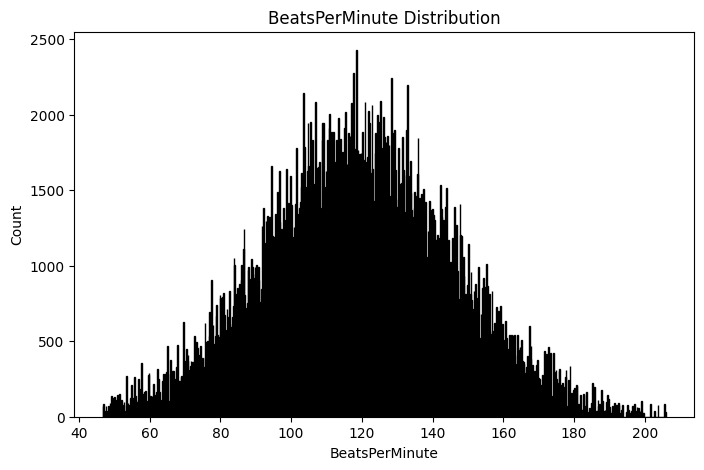

In [22]:
plot_target_distribution(training_df, t_target)

The **BeatsPerMinute** histogram shows a broad spread typical of mixed genres, with the bulk of tracks sitting in the common musical range (roughly moderato to allegro). You may notice mild clustering around tempo “equivalents” (e.g., ~60 and ~120 BPM) due to human perception and annotation habits—double/half-time interpretations often create secondary peaks. The tail behavior looks well-behaved (few extreme outliers), which is good news for RMSE.

**Modeling takeaway:** Because RMSE punishes large errors, watch for octave (×2/÷2) mistakes; a simple tempo-equivalence post-check (e.g., comparing predictions against ½×/2× variants) can reduce those.


### Feature distributions

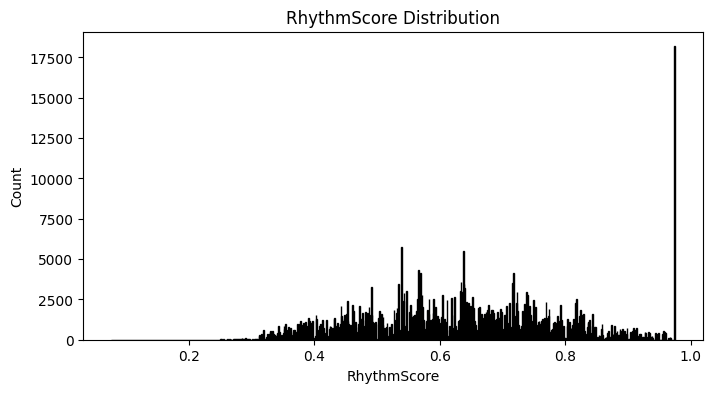

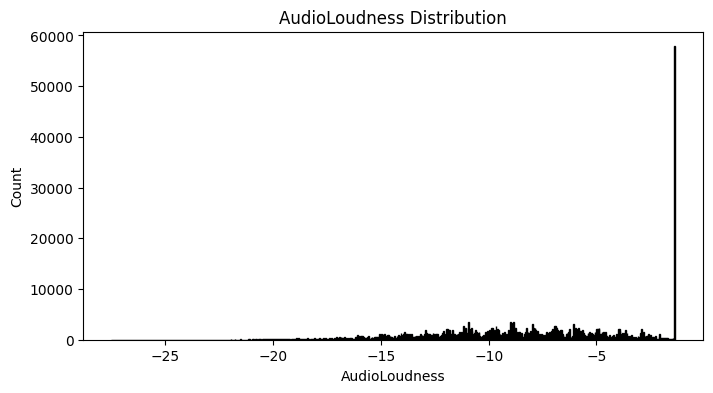

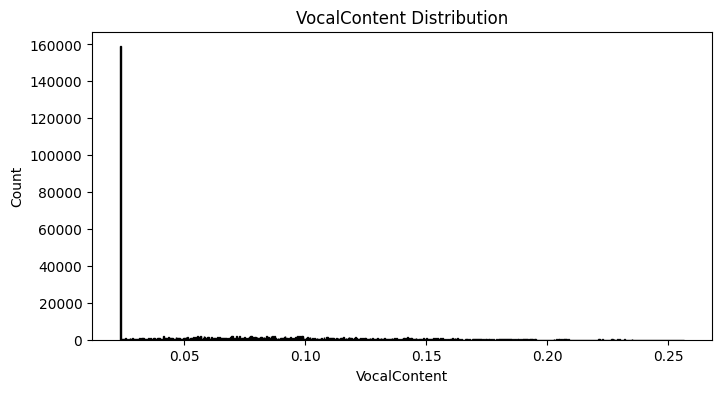

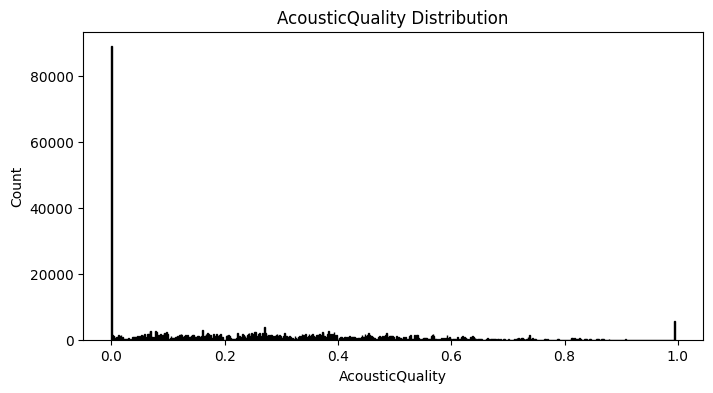

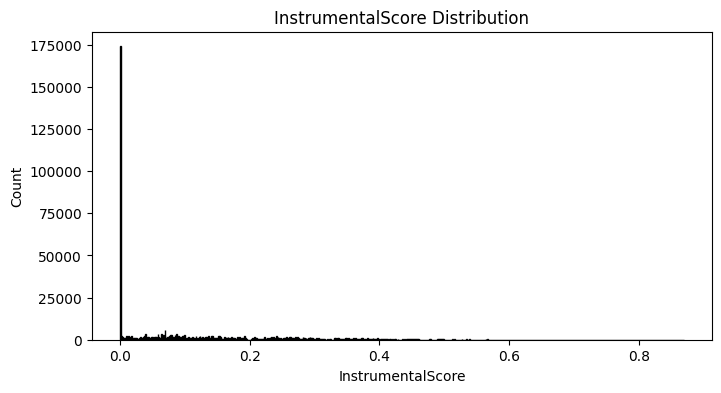

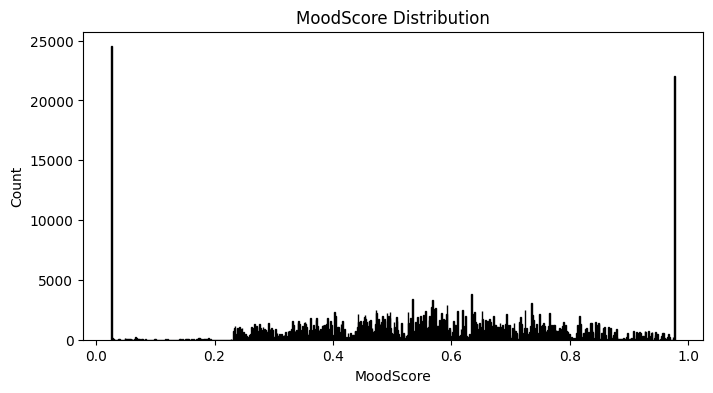

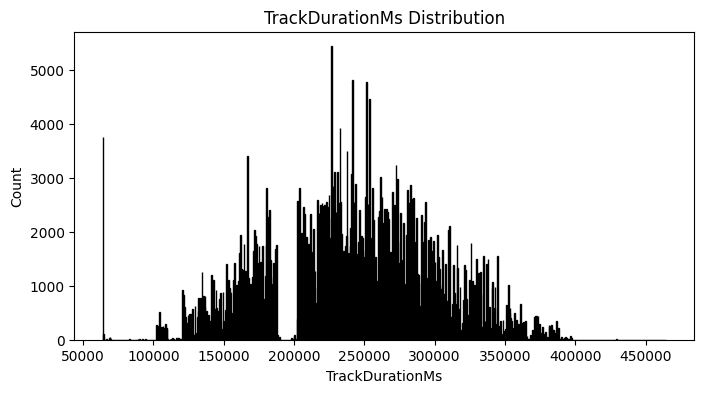

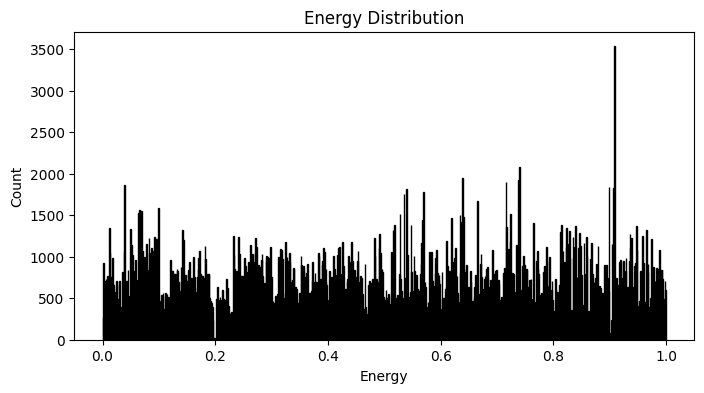

In [23]:
plot_feature_distributions(training_df, t_num)

Across the 9 numeric features, distributions are mostly bounded and interpretable:

* **AudioLoudness** (dBFS, typically negative) is concentrated within a practical production range; extreme values are rare. Consider standardization before linear models.
* **Energy (0–1)** is spread across the unit interval; density tends to be higher in low-to-mid and mid-to-high regions depending on genre balance.
* **RhythmScore (0–1)** and **AcousticQuality (0–1)** show usable variance without heavy tails; they’re good candidates for interaction terms with Energy.
* **VocalContent (0–1)** and **InstrumentalScore (0–1)** are complementary descriptors of mix/arrangement; both exhibit natural floor/ceiling effects (plenty of low or high values).
* **MoodScore (0–1)** is centered enough to be informative without dominating scale. 
* **TrackDurationMs** is **right-skewed** (as expected for track lengths). Most tracks fall in the 2–6 minute band; a **log1p** transform can stabilize variance for linear models.  There is also a **strange blank range of values** around 18500-20000 that should be addressed somehow.
    
**Modeling takeaway:** Consider scaling numeric features (Standard/RobustScaler), and try **log1p(TrackDurationMs)**. Interaction terms like Energy × RhythmScore (or monotonic splines on Energy) are promising.

### Feature ↔ target relationships (hexbin)

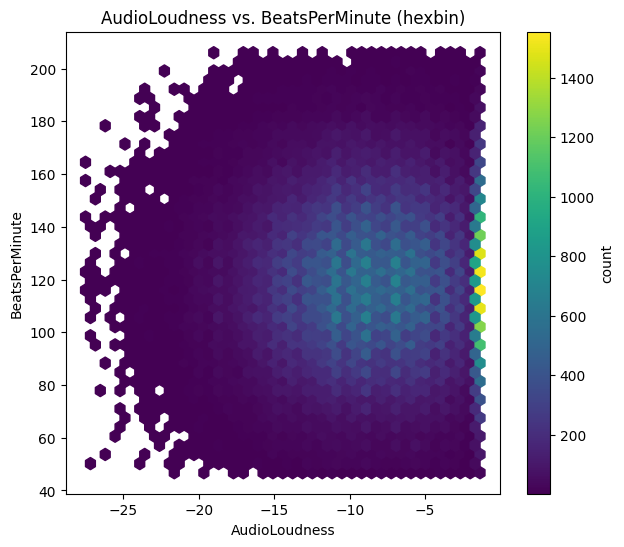

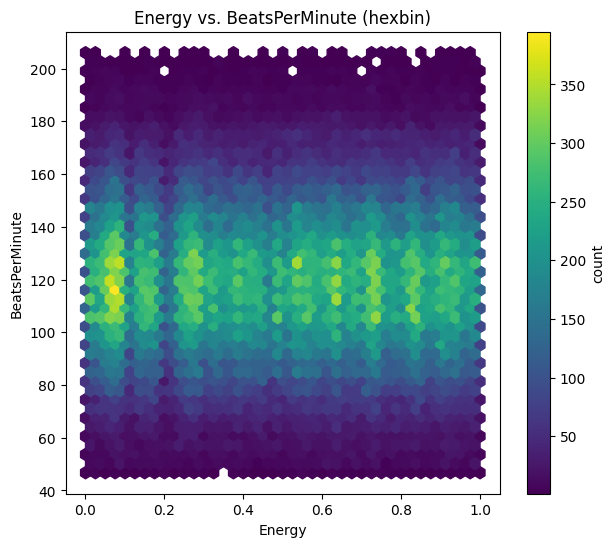

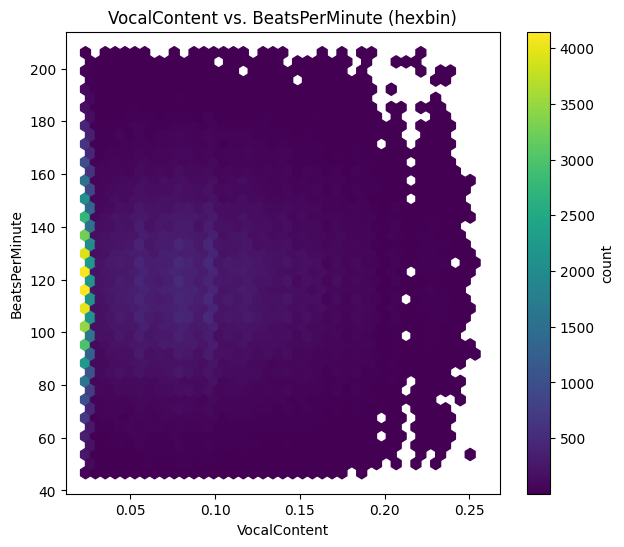

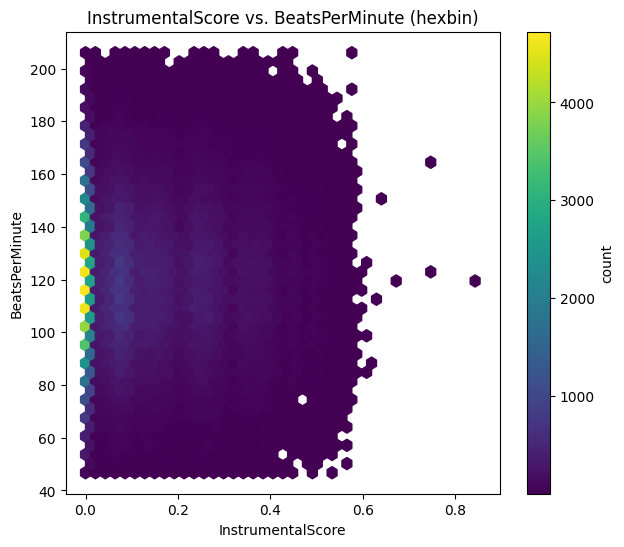

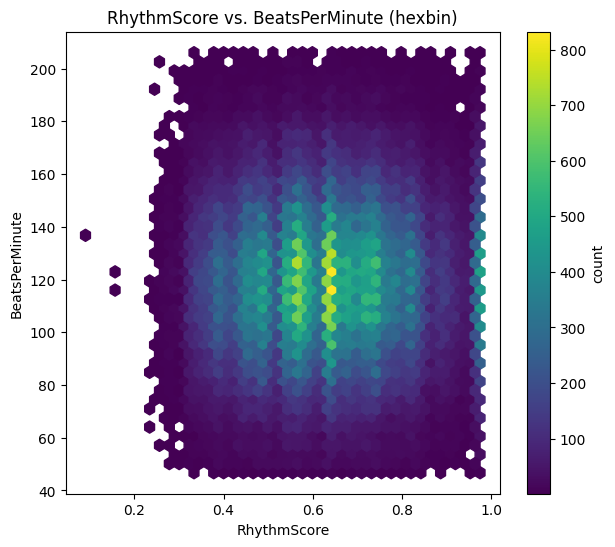

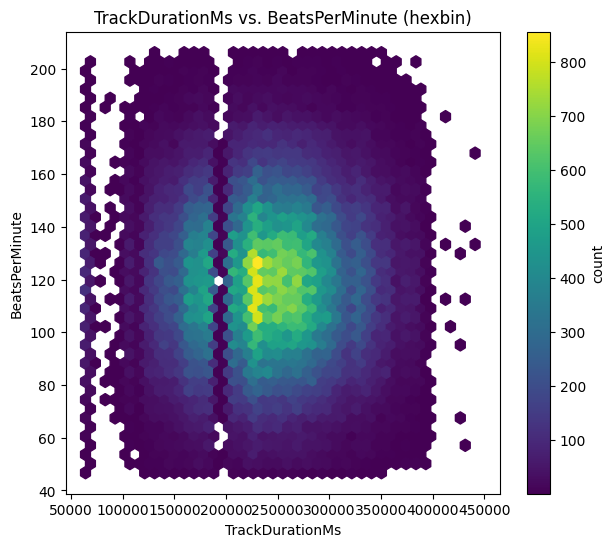

In [24]:
plot_feature_target_relationships(training_df, t_target, t_num)

Hexbin plots make the dense regions readable:

* **Energy ↔ BPM:** Clear **positive** association—tracks with higher Energy tend to have higher BPM, with a hint of saturation at the extremes.
* **AudioLoudness ↔ BPM:** **Weak–moderate positive** trend; louder mixes correlate slightly with faster tempos (production style, not causality).
* **RhythmScore ↔ BPM:** Light positive slope—useful but not as strong as Energy.
* **VocalContent/InstrumentalScore ↔ BPM:** Patterns are **diffuse**; these features likely act via **interactions** (genre/context) rather than a strong marginal effect.
* **TrackDurationMs ↔ BPM:** Essentially **weak**; any pattern is small compared to within-tempo variance. If residuals fan out by duration, a log transform can help.

**Modeling takeaway:** Favor models that capture **non-linearities and interactions** (GBMs/CatBoost/LightGBM, or linear models with engineered interactions). Keep Energy prominent; treat loudness/rhythm as supportive predictors.

## Missing values overview

In [25]:
plot_missing_values(training_df)

No missing values detected.


The notebook reports **No missing values detected.** That simplifies the pipeline—no imputation branch is needed.
    
**Modeling takeaway:** We can keep preprocessing lean; just ensure identical scaling/encoding is applied to train and test.

### Rank relationships numerically

In [26]:
show_relationship_rank(training_df)

([('AcousticQuality', 'Energy', 0.4181836461567918),
  ('Energy', 'LivePerformanceLikelihood', 0.2662560533796248),
  ('Energy', 'MoodScore', 0.2417129961092973),
  ('AudioLoudness', 'Energy', 0.1924110037929794),
  ('Energy', 'RhythmScore', 0.14734982579296899),
  ('LivePerformanceLikelihood', 'VocalContent', 0.12029366153059826),
  ('MoodScore', 'VocalContent', 0.058675264327181675),
  ('Energy', 'TrackDurationMs', 0.04859663736681926),
  ('AcousticQuality', 'MoodScore', 0.03704715686042437),
  ('LivePerformanceLikelihood', 'RhythmScore', 0.0315350455881705)],
 [('AcousticQuality', 'Energy', 0.4400853391571858),
  ('Energy', 'LivePerformanceLikelihood', 0.2807073455596197),
  ('Energy', 'MoodScore', 0.2303466893152495),
  ('AudioLoudness', 'Energy', 0.2032582406213245),
  ('Energy', 'RhythmScore', 0.1654264646436655),
  ('LivePerformanceLikelihood', 'VocalContent', 0.15592137575931672),
  ('MoodScore', 'VocalContent', 0.07130530643581397),
  ('Energy', 'TrackDurationMs', 0.0490938825

Correlation ranking among numeric features highlights where information overlaps (Pearson on the left, Spearman on the right). Your top pairs:
* **AcousticQuality ↔ Energy**: **0.418** (Pearson) / **0.440** (Spearman) — strongest overall; potential redundancy/interaction.
* **Energy ↔ LivePerformanceLikelihood**: **0.266** / **0.281** — moderate alignment.
* **Energy ↔ MoodScore**: **0.242** / **0.230** — modest positive link.
* **AudioLoudness ↔ Energy**: **0.192** / **0.203** — weak–moderate.
* **Energy ↔ RhythmScore**: **0.147** / **0.165** — weak–moderate.
* **LivePerformanceLikelihood ↔ VocalContent**: **0.120** / **0.156** — weak–moderate.
* Others (e.g., **Energy ↔ TrackDurationMs** ~**0.049** Pearson; **Energy ↔ InstrumentalScore** ~**0.043** Spearman) are **weak**.

**Modeling takeaway:** Correlations are **not high** (≤ ~0.44), which is good—features are not collinear clones. Still, the **Energy cluster** (Energy with AcousticQuality/Loudness/Rhythm/Mood) suggests trying either (a) a tree/boosting model that naturally captures these interactions, or (b) a linear model with a small set of engineered interaction terms. Regularization (L1/L2/ElasticNet) will guard against overfit.

## Examine Original Dataset

This challenge is based on the [**BPM Prediction Challenge**](https://www.kaggle.com/datasets/gauravduttakiit/bpm-prediction-challenge) dataset.  Let's examine this dataset to see if the current dataset differs.

In [27]:
ORIGINAL_DIR = Path("/kaggle/input/bpm-prediction-challenge") if running_in_kaggle() else Path("original_data")

original_df = pd.read_csv(ORIGINAL_DIR / 'Train.csv')
original_df

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
0,0.513,-7.812,0.071,0.065,0.109,0.316,0.737,"328,639.319",0.556,117.092
1,0.775,-6.819,0.024,0.511,0.187,0.024,0.259,"271,967.983",0.411,122.002
2,0.636,-19.782,0.063,0.428,0.002,0.024,0.055,"186,147.003",0.533,149.131
3,0.232,-14.957,0.024,0.076,0.000,0.228,0.745,"321,734.972",0.659,95.832
4,0.759,-4.716,0.024,0.264,0.415,0.197,0.967,"179,973.398",0.230,125.696
...,...,...,...,...,...,...,...,...,...,...
14628,0.769,-13.609,0.042,0.551,0.127,0.024,0.509,"223,465.581",0.474,82.317
14629,0.267,-8.657,0.024,0.219,0.161,0.287,0.764,"135,276.088",0.148,132.108
14630,0.469,-1.962,0.024,0.912,0.153,0.227,0.619,"134,735.859",0.423,83.344
14631,0.588,-9.766,0.024,0.000,0.050,0.341,0.178,"187,951.229",0.340,121.297


In [28]:
coerce_numeric(original_df, ["TrackDurationMs"])

In [29]:
eda_summary(original_df)

======== First 5 Rows ========


,0,1,2,3,4
RhythmScore,0.513,0.775,0.636,0.232,0.759
AudioLoudness,-7.812,-6.819,-19.782,-14.957,-4.716
VocalContent,0.071,0.024,0.063,0.024,0.024
AcousticQuality,0.065,0.511,0.428,0.076,0.264
InstrumentalScore,0.109,0.187,0.002,0.000,0.415
LivePerformanceLikelihood,0.316,0.024,0.024,0.228,0.197
MoodScore,0.737,0.259,0.055,0.745,0.967
TrackDurationMs,"328,639.319","271,967.983","186,147.003","321,734.972","179,973.398"
Energy,0.556,0.411,0.533,0.659,0.230
BeatsPerMinute,117.092,122.002,149.131,95.832,125.696



======== DataFrame Info ========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14633 entries, 0 to 14632
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   RhythmScore                14633 non-null  float64
 1   AudioLoudness              14633 non-null  float64
 2   VocalContent               14633 non-null  float64
 3   AcousticQuality            14633 non-null  float64
 4   InstrumentalScore          14633 non-null  float64
 5   LivePerformanceLikelihood  14633 non-null  float64
 6   MoodScore                  14633 non-null  float64
 7   TrackDurationMs            14633 non-null  float64
 8   Energy                     14633 non-null  float64
 9   BeatsPerMinute             14633 non-null  float64
dtypes: float64(10)
memory usage: 1.1 MB

======== Descriptive Statistics (Numeric Columns) ========


,count,mean,std,min,25%,50%,75%,max
RhythmScore,"14,633.000",0.597,0.177,0.077,0.474,0.600,0.721,0.975
AudioLoudness,"14,633.000",-8.442,4.728,-27.510,-11.659,-8.236,-4.830,-1.357
VocalContent,"14,633.000",0.084,0.058,0.024,0.024,0.073,0.123,0.346
AcousticQuality,"14,633.000",0.281,0.238,0.000,0.062,0.253,0.442,0.995
InstrumentalScore,"14,633.000",0.137,0.158,0.000,0.000,0.083,0.237,0.890
LivePerformanceLikelihood,"14,633.000",0.193,0.135,0.024,0.075,0.180,0.288,0.803
MoodScore,"14,633.000",0.524,0.242,0.026,0.352,0.526,0.699,0.978
TrackDurationMs,"14,633.000","241,743.825","67,216.815","63,973.000","196,588.624","241,235.859","286,987.806","519,650.691"
Energy,"14,633.000",0.501,0.289,0.000,0.251,0.501,0.751,1.000
BeatsPerMinute,"14,633.000",118.969,26.566,46.718,100.888,118.734,136.729,206.037



======== Descriptive Statistics (Categorical Columns) ========
No categorical columns found.

======== Missing Values Summary ========


,Missing Count,Percentage
RhythmScore,0,0.000
AudioLoudness,0,0.000
VocalContent,0,0.000
AcousticQuality,0,0.000
InstrumentalScore,0,0.000
LivePerformanceLikelihood,0,0.000
MoodScore,0,0.000
TrackDurationMs,0,0.000
Energy,0,0.000
BeatsPerMinute,0,0.000



======== Duplicated Rows ========
Total duplicated rows: 0

======== Data Types Count ========


float64    10
Name: count, dtype: int64


======== Correlation Matrix (Numeric Columns) ========


,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
RhythmScore,1.000,-0.003,-0.018,0.003,0.005,-0.006,-0.004,-0.007,-0.148,-0.001
AudioLoudness,-0.003,1.000,0.007,0.019,0.009,-0.007,0.002,-0.017,0.141,0.007
VocalContent,-0.018,0.007,1.000,-0.007,-0.011,0.001,0.005,-0.008,0.016,-0.004
AcousticQuality,0.003,0.019,-0.007,1.000,0.009,-0.010,-0.014,0.002,-0.337,0.007
InstrumentalScore,0.005,0.009,-0.011,0.009,1.000,-0.010,0.000,0.006,0.015,-0.007
LivePerformanceLikelihood,-0.006,-0.007,0.001,-0.010,-0.010,1.000,-0.001,-0.003,-0.300,0.010
MoodScore,-0.004,0.002,0.005,-0.014,0.000,-0.001,1.000,0.009,-0.200,0.005
TrackDurationMs,-0.007,-0.017,-0.008,0.002,0.006,-0.003,0.009,1.000,0.072,0.009
Energy,-0.148,0.141,0.016,-0.337,0.015,-0.300,-0.200,0.072,1.000,-0.009
BeatsPerMinute,-0.001,0.007,-0.004,0.007,-0.007,0.010,0.005,0.009,-0.009,1.000



======== Value Counts for Categorical Columns (Low Cardinality) ========
No categorical columns found.


In [30]:
target_col, num_cols = describe_df(original_df)
o_target, o_num = describe_df(original_df)

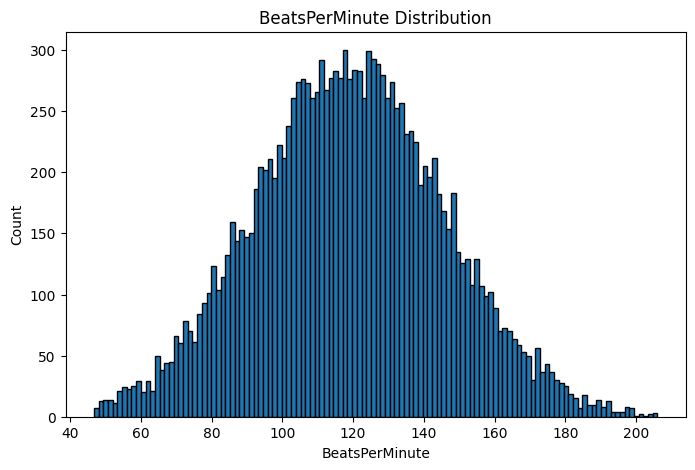

In [31]:
plot_target_distribution(original_df, o_target)

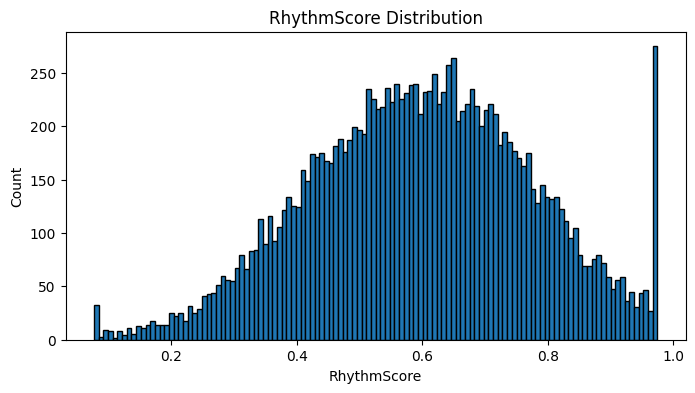

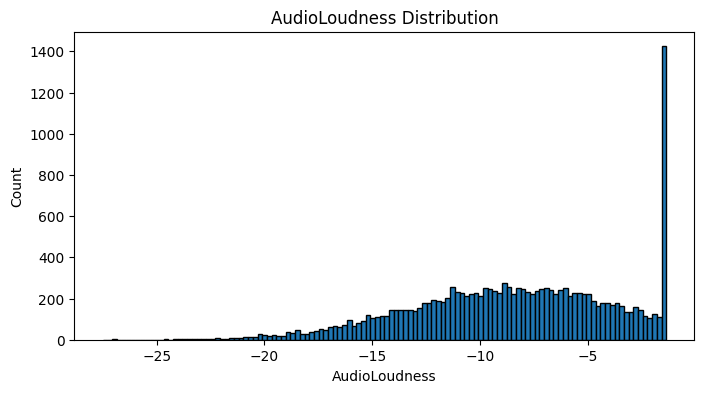

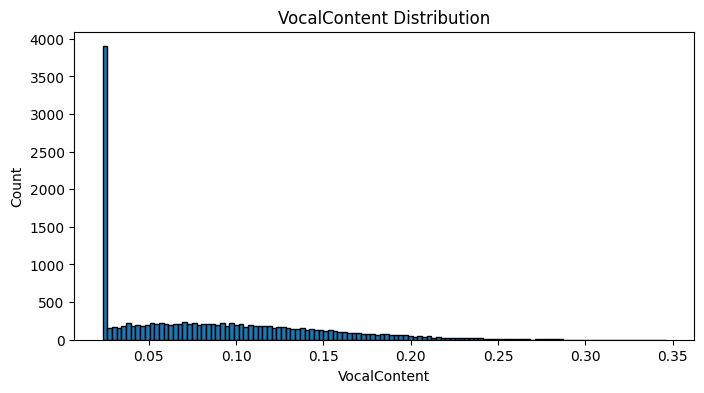

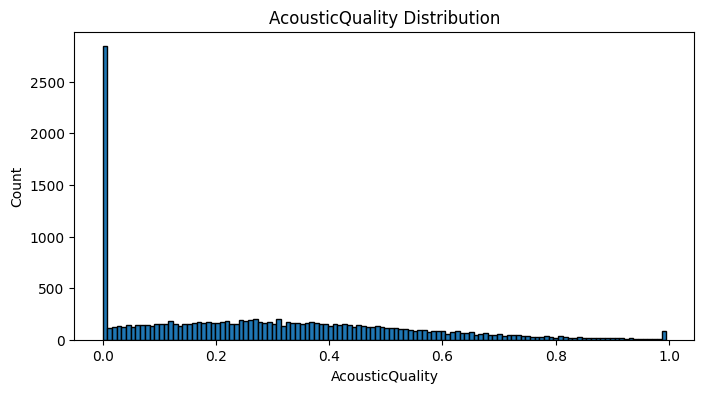

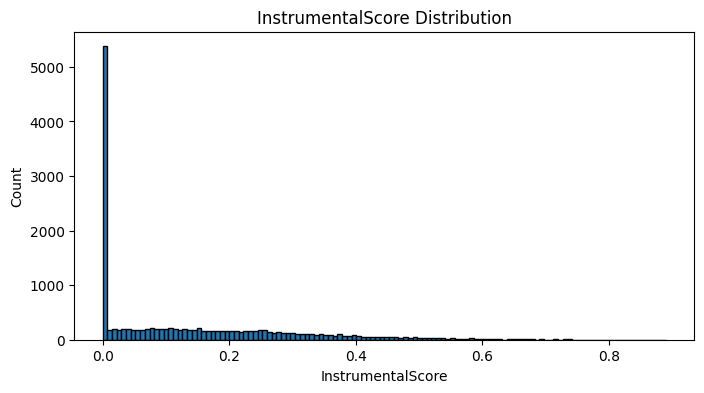

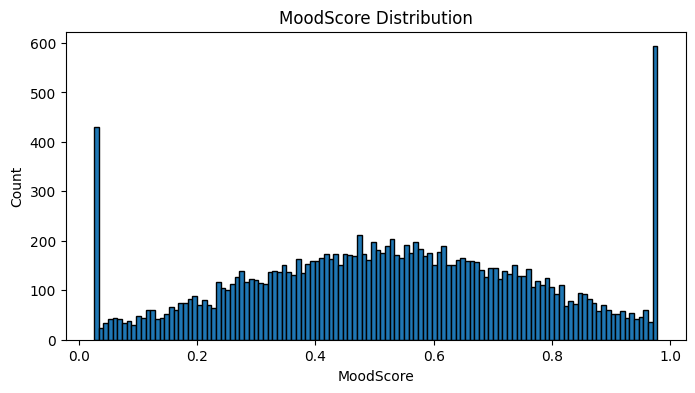

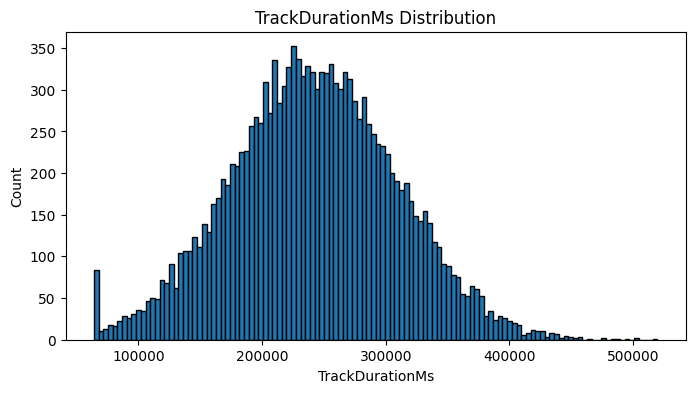

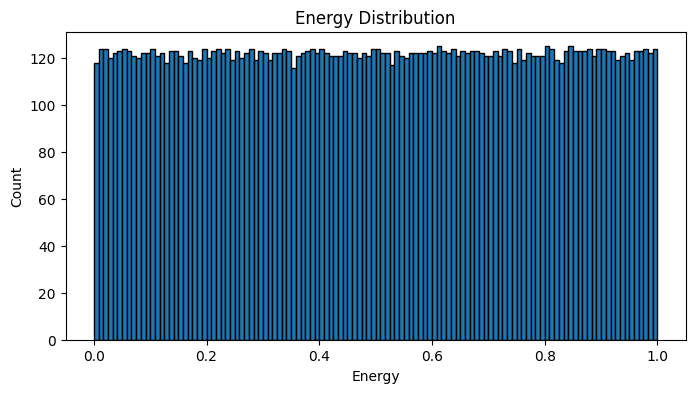

In [32]:
plot_feature_distributions(original_df, o_num)

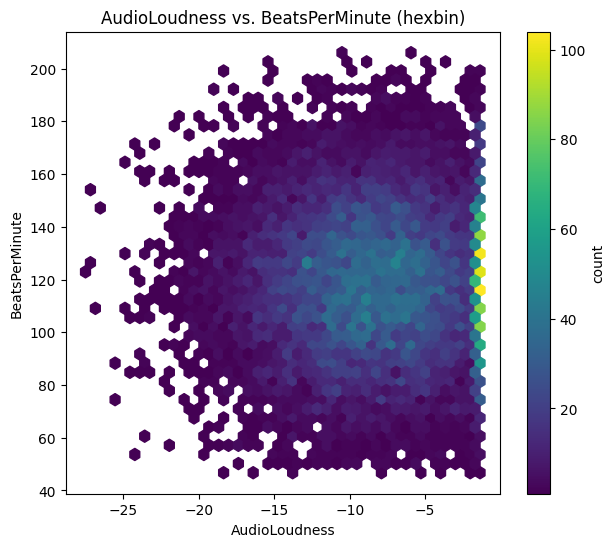

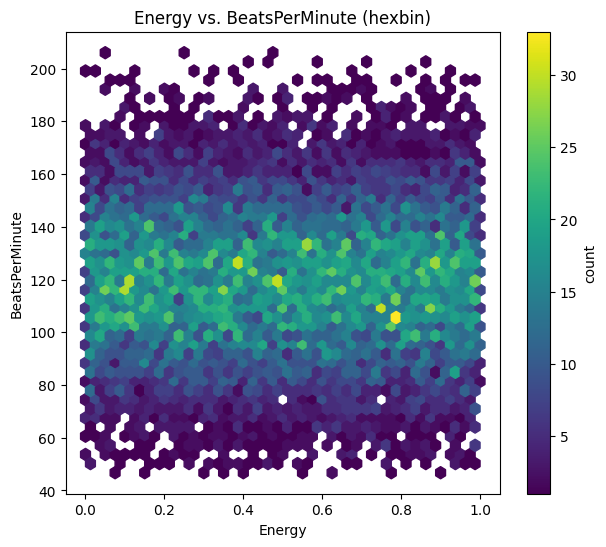

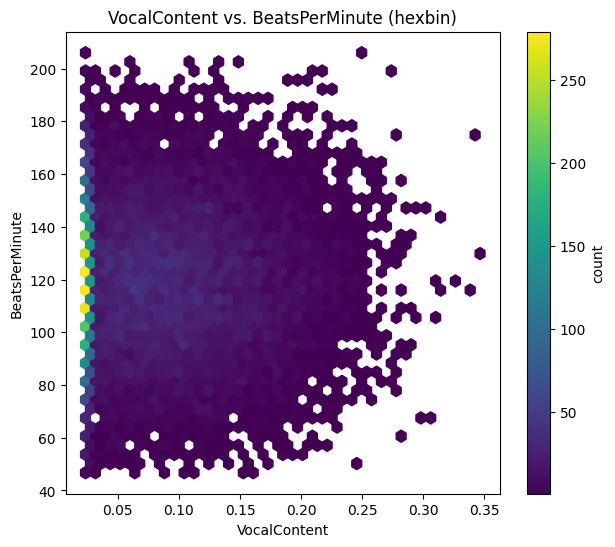

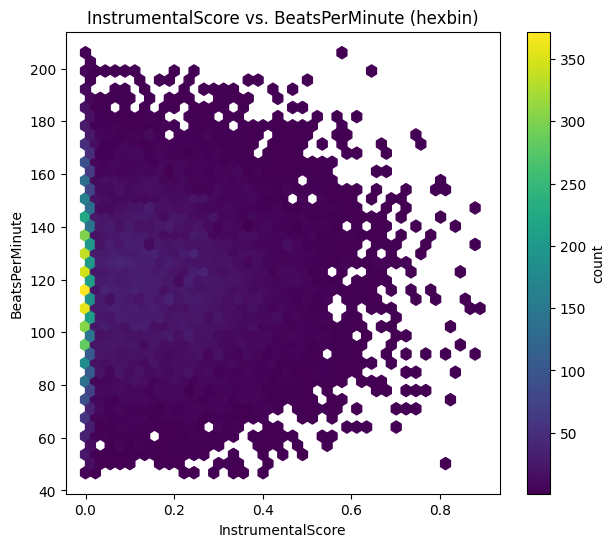

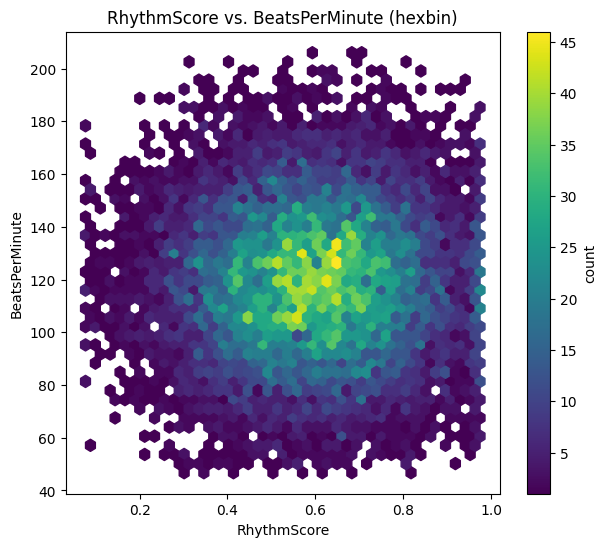

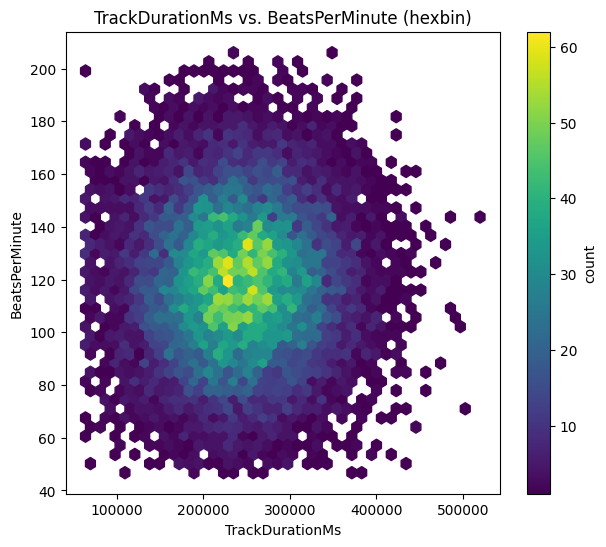

In [33]:
plot_feature_target_relationships(original_df, o_target, o_num)

In [34]:
plot_missing_values(original_df)

No missing values detected.


In [35]:
show_relationship_rank(original_df)

([('AcousticQuality', 'Energy', 0.33693075026580765),
  ('Energy', 'LivePerformanceLikelihood', 0.299545201419133),
  ('Energy', 'MoodScore', 0.1998907857049842),
  ('Energy', 'RhythmScore', 0.14763367790093976),
  ('AudioLoudness', 'Energy', 0.14132299688139244),
  ('Energy', 'TrackDurationMs', 0.07229254467946314),
  ('AcousticQuality', 'AudioLoudness', 0.019255955712905223),
  ('RhythmScore', 'VocalContent', 0.018010914719261698),
  ('AudioLoudness', 'TrackDurationMs', 0.01744693348767214),
  ('Energy', 'VocalContent', 0.015599943829410805)],
 [('AcousticQuality', 'Energy', 0.34916100684463725),
  ('Energy', 'LivePerformanceLikelihood', 0.3245479623835706),
  ('Energy', 'MoodScore', 0.19315772091457167),
  ('Energy', 'RhythmScore', 0.16012055564918118),
  ('AudioLoudness', 'Energy', 0.15283597401362356),
  ('Energy', 'TrackDurationMs', 0.07538668674199708),
  ('AcousticQuality', 'AudioLoudness', 0.02053898884763602),
  ('RhythmScore', 'VocalContent', 0.01863259933400978),
  ('Energy

## Dataset Comparison Report

**Shapes** — Contest: 524,164 rows × 10 cols; Original: 14,633 rows × 10 cols.
**Missing values** — Contest: 0; Original: 0.  **Duplicates** — Contest: 0; Original: 0.

**Largest spread differences (|Δ std|):**
- **TrackDurationMs**: Δstd = -7890.2140
- **AudioLoudness**: Δstd = -0.1116
- **BeatsPerMinute**: Δstd = -0.0980
- **InstrumentalScore**: Δstd = -0.0265
- **RhythmScore**: Δstd = -0.0200

**Largest tail differences (|Δ max|):**
- **TrackDurationMs**: Δmax = -54927.4630
- **LivePerformanceLikelihood**: Δmax = -0.2032
- **VocalContent**: Δmax = -0.0900
- **InstrumentalScore**: Δmax = -0.0211
- **RhythmScore**: Δmax = +0.0000

**Largest center differences (|Δ mean|):**
- **TrackDurationMs**: Δmean = +159.8680
- **BeatsPerMinute**: Δmean = +0.0661
- **AudioLoudness**: Δmean = +0.0626
- **RhythmScore**: Δmean = +0.0355
- **MoodScore**: Δmean = +0.0321

**Top correlations with `BeatsPerMinute` (Contest)**: MoodScore +0.007, TrackDurationMs +0.007, RhythmScore +0.005, VocalContent +0.005, Energy -0.004.
**Top correlations with `BeatsPerMinute` (Original)**: LivePerformanceLikelihood +0.010, TrackDurationMs +0.009, Energy -0.009, AudioLoudness +0.007, InstrumentalScore -0.007.

## Feature Engineering

The analysis above suggests the following tasks to ready the data from training:

1. **Outlier-proof using quantile clipping (winsorization)** Fit per-feature lower/upper bounds on the **training split** (e.g., 0.2%–99.8%) and clip both train & test to those bounds. This keeps models stable if we later score “Original”-like extremes.
2. **Stabilize skew** Apply log1p to TrackDurationMs.  For AudioLoudness, optionally flip sign to “loudness magnitude” (-AudioLoudness, so bigger = louder)
3. **Robust scale only the “odd units”** Use RobustScaler on log1p(TrackDurationMs) and (optionally) loudness\_magnitude. Leave the 0–1 features as-is.
4. **Optionally add a few targeted interactions (for linear models)** Add interactions that EDA suggests matter:Energy×AcousticQuality, Energy×LivePerformanceLikelihood, Energy×MoodScore, Energy×(loudness).
5. **(Optional) Target transform** Wrap the regressor in TransformedTargetRegressor(PowerTransformer(‘yeo-johnson’)) if residuals look heteroscedastic. Undoing transform is automatic.
6. **Prefer tree ensembles for baseline** With minimal transforms (clip + log duration), Gradient Boosting / LightGBM / XGBoost will usually beat linear since single-feature correlations with BPM are weak.

In [36]:
from dataclasses import dataclass, field
from typing import List, Optional, Tuple
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import PolynomialFeatures
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

@dataclass
class PandasPreprocessor:
    """
    Pandas-based preprocessing with train-only winsorization, robust transforms,
    and engineered interaction features. It now includes integrated memory reduction.

    Steps on `fit(df)`:
      1) Reduce memory usage of the DataFrame.
      2) Learn per-feature quantile clip thresholds for ALL numeric columns.
      3) Learn robust stats (median/IQR) for scaling.
      4) Learn top N features for selective polynomial interactions.

    Steps on `transform(df)`:
      1) Clip ALL numeric columns using learned quantiles (winsorize).
      2) Overwrite existing columns with specialized transforms.
      3) Create and append selective polynomial interactions.
      4) Ensure all numeric columns are float32 for XGBoost.
      5) Optionally drop the target column for X.

    Parameters
    ----------
    target_col : str or None
        Target column to drop when `drop_target=True` in `transform`.
    duration_col : str
        Column name for track duration in milliseconds.
    loudness_col : str
        Column name for loudness in dB (typically negative values).
    winsor_q : (float, float)
        Lower/upper quantiles for winsorization across numeric columns.
    eps : float
        Small constant for safe division in ratios.
    add_interactions : bool
        Whether to append engineered interaction features in `transform`.
    long_quantile : float
        Quantile threshold for `long_track` (applied on log1p(duration)).
    high_energy_threshold : float
        Threshold for `high_energy = ReLU(Energy - high_energy_threshold)`.
    low_energy_threshold : float
        Threshold for `low_energy  = ReLU(low_energy_threshold - Energy)`.
    poly_features_degree : int
        Degree for polynomial features (e.g., 2 for squared and interactions).
    poly_features_n : int
        Number of top features to use for generating polynomial interactions.
    use_float16 : bool
        Whether to use float16 for memory reduction (can be less precise).

    Attributes learned on fit
    -------------------------
    numeric_cols_ : list[str]
        Numeric feature columns (excluding `target_col`).
    q_low_, q_high_ : pd.Series
        Per-column winsorization thresholds.
    duration_median_, duration_iqr_ : float
        Robust stats for log1p(duration) scaling.
    loud_median_, loud_iqr_ : float
        Robust stats for -AudioLoudness scaling.
    long_duration_thresh_ : float
        Learned threshold for `long_track`.
    instr_floor_: float
        Learned floor for instrumental score.
    v2i_low_, v2i_high_: float
        Learned clipping thresholds for vocal-to-instrumental ratio.
    top_features_: List[str]
        Column names of the top features identified for polynomial interactions.
    """
    target_col: Optional[str] = None
    duration_col: str = "TrackDurationMs"
    loudness_col: str = "AudioLoudness"
    winsor_q: Tuple[float, float] = (0.002, 0.998)
    eps: float = 1e-9
    ratio_floor_quantile: float = 0.05      # floor denom at this train quantile
    ratio_clip_q: Tuple[float, float] = (0.01, 0.99) # clip raw ratio to these train quantiles

    # engineered-feature controls
    add_interactions: bool = True
    long_quantile: float = 0.95
    high_energy_threshold: float = 0.70
    low_energy_threshold: float = 0.30

    # New: Polynomial Feature controls
    poly_features_degree: int = 2
    poly_features_n: int = 10
    use_float16: bool = False

    # learned parameters (filled on fit)
    numeric_cols_: List[str] = field(default_factory=list)
    q_low_: pd.Series = field(default=None)
    q_high_: pd.Series = field(default=None)
    duration_median_: float = 0.0
    duration_iqr_: float = 1.0
    loud_median_: float = 0.0
    loud_iqr_: float = 1.0
    long_duration_thresh_: float = 0.0
    instr_floor_: float = 0.0
    v2i_low_: float = 0.0
    v2i_high_: float = 0.0
    top_features_: List[str] = field(default_factory=list)

    # ------------------------ internals ------------------------

    def _num_cols(self, df: pd.DataFrame) -> List[str]:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()
        if self.target_col in cols:
            cols.remove(self.target_col)
        return cols

    def _has(self, df: pd.DataFrame, name: str) -> bool:
        return name in df.columns

    def _reduce_mem_usage(self, df: pd.DataFrame) -> pd.DataFrame:
        """Iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
        """
        start_mem = df.memory_usage().sum() / 1024**2
        print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
        
        for col in df.columns:
            if is_datetime(df[col]) or is_categorical_dtype(df[col]):
                # skip datetime type or categorical type
                continue
            col_type = df[col].dtype
            
            if col_type != object:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64) 
                else:
                    if self.use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
            else:
                df[col] = df[col].astype('category')

        end_mem = df.memory_usage().sum() / 1024**2
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
        
        return df
        
    def _add_v2i_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Add vocal/instrumentation ratio features using *training-learned* stats:
        - self.q_low_, self.q_high_
        - self.instr_floor_, self.v2i_low_, self.v2i_high_
        """
        if not (self._has(df, "VocalContent") and self._has(df, "InstrumentalScore")):
            return df

        # need a copy since we'll be adding columns
        out = df.copy()
    
        v = out["VocalContent"].clip(self.q_low_["VocalContent"], self.q_high_["VocalContent"])
        i = out["InstrumentalScore"].clip(self.q_low_["InstrumentalScore"], self.q_high_["InstrumentalScore"])

        # use training-learned floor/quantiles (already computed in fit)
        denom = np.maximum(i, self.instr_floor_ + self.eps)
        ratio = v / denom
        ratio = ratio.clip(self.v2i_low_, self.v2i_high_)

        out["vocal_to_instr"] = ratio
        out["vocal_to_instr_log1p"] = np.log1p(ratio)
        out["vocal_to_instr_asinh"] = np.arcsinh(ratio)
        return out

    # ------------------------ API ------------------------

    def fit(self, df: pd.DataFrame):
        df = df.copy()
        
        # New: Reduce memory usage first
        df = self._reduce_mem_usage(df)

        self.numeric_cols_ = self._num_cols(df)

        # --- winsorization thresholds on ALL numeric cols ---
        q_low, q_high = self.winsor_q
        self.q_low_ = df[self.numeric_cols_].quantile(q_low)
        self.q_high_ = df[self.numeric_cols_].quantile(q_high)

        # --- robust stats for VocalContent / InstrumentalScore ratio (train-only) ---
        if self._has(df, "VocalContent") and self._has(df, "InstrumentalScore"):
            v = df["VocalContent"].clip(self.q_low_["VocalContent"], self.q_high_["VocalContent"])
            i = df["InstrumentalScore"].clip(self.q_low_["InstrumentalScore"], self.q_high_["InstrumentalScore"])

            # denominator floor at a train quantile (e.g., 5th percentile)
            self.instr_floor_ = float(np.quantile(i, self.ratio_floor_quantile))
            denom = np.maximum(i, self.instr_floor_ + self.eps)

            ratio = v / denom
            ql, qh = self.ratio_clip_q
            self.v2i_low_ = float(np.quantile(ratio, ql))
            self.v2i_high_ = float(np.quantile(ratio, qh))

            # Add more features based on vocal to instrumentation
            df = self._add_v2i_features(df)
        
        # --- robust stats for duration (after log1p of CLIPPED duration) ---
        if self._has(df, self.duration_col):
            dur_clipped = df[self.duration_col].clip(self.q_low_[self.duration_col],
                                                     self.q_high_[self.duration_col])
            dur_log = np.log1p(dur_clipped)
            self.duration_median_ = float(dur_log.median())
            self.duration_iqr_ = float(dur_log.quantile(0.75) - dur_log.quantile(0.25)) or 1.0
            # long-track threshold learned on train
            self.long_duration_thresh_ = float(dur_log.quantile(self.long_quantile))

        # --- robust stats for loudness (after negation of CLIPPED loudness) ---
        if self._has(df, self.loudness_col):
            loud_clipped = df[self.loudness_col].clip(self.q_low_[self.loudness_col],
                                                      self.q_high_[self.loudness_col])
            loud_mag = -loud_clipped
            self.loud_median_ = float(loud_mag.median())
            self.loud_iqr_ = float(loud_mag.quantile(0.75) - loud_mag.quantile(0.25)) or 1.0
            
        # --- NEW: Learn top features for selective polynomial interactions ---
        if self.add_interactions:
            # Drop the target column to train the model
            X_temp = df.drop(columns=[self.target_col])
            y_temp = df[self.target_col].copy()

            # Train a quick, simple model to get feature importances.
            temp_model = xgb.XGBRegressor(
                n_estimators=100,
                learning_rate=0.1,
                max_depth=5,
                tree_method='hist',
                device='cuda' if USE_GPU else 'cpu',
                seed=seed
            )
            temp_model.fit(X_temp, y_temp)

            # Get feature importances and sort them
            importances = temp_model.feature_importances_
            feature_names = X_temp.columns
            sorted_indices = np.argsort(importances)[::-1]
            self.top_features_ = feature_names[sorted_indices][:self.poly_features_n].tolist()

        return self

    def transform(self, df: pd.DataFrame, drop_target: bool = True) -> pd.DataFrame:
        df = df.copy()

        # 1) winsorize all numeric columns in-place
        for c in self.numeric_cols_:
            lo = self.q_low_[c]
            hi = self.q_high_[c]
            df[c] = df[c].clip(lo, hi)

        # 2) specialized transforms (overwrite columns; also create base features)
        # duration: log1p -> robust scale; also expose raw log_duration
        if self._has(df, self.duration_col):
            dur_log_raw = np.log1p(df[self.duration_col])  # after winsorization
            df["log_duration"] = dur_log_raw
            df[self.duration_col] = (dur_log_raw - self.duration_median_) / (self.duration_iqr_ + self.eps)

        # loudness: negate -> robust scale; also expose loud_mag (pre-scale)
        if self._has(df, self.loudness_col):
            loud_mag_raw = -df[self.loudness_col]  # after winsorization
            df["loud_mag"] = loud_mag_raw
            df[self.loudness_col] = (loud_mag_raw - self.loud_median_) / (self.loud_iqr_ + self.eps)

        # 3) engineered features
        if self.add_interactions:
            # helpers
            def has(name: str) -> bool:
                return name in df.columns

            def add_prod(a: str, b: str, name: str):
                if has(a) and has(b):
                    df[name] = df[a] * df[b]

            # simple curvature
            if has("Energy"):
                df["Energy_sq"] = df["Energy"] ** 2

            # pairwise products
            add_prod("Energy", "RhythmScore", "drive")
            add_prod("Energy", "LivePerformanceLikelihood", "stage")
            if has("Energy") and has("loud_mag"):
                df["bright"] = df["Energy"] * df["loud_mag"]
            add_prod("Energy", "MoodScore", "mood_energy")
            add_prod("AcousticQuality", "Energy", "acoustic_energy")
            add_prod("RhythmScore", "MoodScore", "rhythm_mood")

            # contrasts / ratios
            if has("VocalContent") and has("InstrumentalScore"):
                v = df["VocalContent"]
                i = df["InstrumentalScore"]

                # 1) raw ratio with train-based floor + clipping to train quantiles
                denom = np.maximum(i, self.instr_floor_ + self.eps)
                ratio = (v / denom).clip(self.v2i_low_, self.v2i_high_)
                df["vocal_to_instr"] = ratio

                # 2) smooth, symmetric log-ratio (finite at zeros)
                df["vocal_log_ratio"] = np.log1p(v) - np.log1p(i + self.eps)

                # 3) bounded relative difference in [-1, 1]
                df["vocal_rel"] = (v - i) / (v + i + self.eps)
                df["vocal_minus_instr"] = df["VocalContent"] - df["InstrumentalScore"]

                df = self._add_v2i_features(df)
                
            if has("Energy") and has("AcousticQuality"):
                df["energy_minus_acoustic"] = df["Energy"] - df["AcousticQuality"]

            # piecewise (hinges) on Energy
            if has("Energy"):
                df["high_energy"] = np.maximum(df["Energy"] - self.high_energy_threshold, 0.0)
                df["low_energy"]  = np.maximum(self.low_energy_threshold - df["Energy"], 0.0)

            # long-track indicator based on TRAIN-learned threshold
            if has("log_duration") and self.long_duration_thresh_ > 0.0:
                df["long_track"] = (df["log_duration"] > self.long_duration_thresh_).astype("int8")

        # 4) Create Selective Polynomial Features
        if self.add_interactions and len(self.top_features_) > 0:
            # Select only the top features from the original DataFrame
            X_top = df[self.top_features_]

            # Use PolynomialFeatures on this smaller, selected set of features
            poly = PolynomialFeatures(
                degree=self.poly_features_degree, 
                interaction_only=True,   # <- keeps x_i * x_j, drops x_i^2
                include_bias=False
            )
            poly_features = poly.fit_transform(X_top)
            
            # Get the new column names and convert back to a DataFrame
            feature_names_out = poly.get_feature_names_out(input_features=X_top.columns)
            
            # Create a DataFrame from the polynomial features
            X_interactions = pd.DataFrame(poly_features, columns=feature_names_out, index=df.index)

            # Get a list of the new columns that are not duplicates of the original columns
            new_poly_cols = [col for col in X_interactions.columns if col not in df.columns]

            # Combine with the full original feature set
            df = pd.concat([df, X_interactions[new_poly_cols]], axis=1)

        # 5) Ensure all numeric columns are float32 for XGBoost
        # This will now work correctly since we have unique column names.
        for col in df.columns:
            if df[col].dtype.kind in 'fi':
                df[col] = df[col].astype(np.float32)

        # 6) optionally drop target for X
        if drop_target and self.target_col in df.columns:
            df = df.drop(columns=[self.target_col])

        return df

    def fit_transform(self, df: pd.DataFrame, drop_target: bool = True) -> pd.DataFrame:
        self.fit(df)
        return self.transform(df, drop_target=drop_target)


In [37]:
pp = PandasPreprocessor(
    target_col="BeatsPerMinute",
    add_interactions=True,        # turn off if you want a pure baseline
    long_quantile=0.95,
    high_energy_threshold=0.70,
    low_energy_threshold=0.30,
)

X_train = pp.fit_transform(training_df, drop_target=True)
y_train = training_df["BeatsPerMinute"].copy()

# Create a validation set with the original data
X_valid = pp.transform(original_df, drop_target=True)
y_valid = original_df["BeatsPerMinute"].copy()

# For validation/test, apply the *same* fitted stats:
X_test = pp.transform(test_df, drop_target=False)

Memory usage of dataframe is 39.99 MB
Memory usage after optimization is: 20.00 MB
Decreased by 50.0%


In [38]:
eda_summary(X_train)

======== First 5 Rows ========


,0,1,2,3,4
RhythmScore,0.604,0.639,0.515,0.734,0.533
AudioLoudness,-0.093,1.207,1.160,-1.039,0.724
VocalContent,0.023,0.072,0.111,0.053,0.023
AcousticQuality,0.000,0.445,0.174,0.002,0.069
InstrumentalScore,0.000,0.349,0.454,0.160,0.000
...,...,...,...,...,...
vocal_to_instr_log1p InstrumentalScore,0.000,0.065,0.099,0.046,0.000
vocal_to_instr_log1p vocal_to_instr,"219,337.891",0.038,0.053,0.095,"219,337.891"
AcousticQuality InstrumentalScore,0.000,0.155,0.079,0.000,0.000
AcousticQuality vocal_to_instr,0.118,0.091,0.042,0.001,"1,507.137"



======== DataFrame Info ========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524164 entries, 0 to 524163
Data columns (total 73 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   RhythmScore                                524164 non-null  float32
 1   AudioLoudness                              524164 non-null  float32
 2   VocalContent                               524164 non-null  float32
 3   AcousticQuality                            524164 non-null  float32
 4   InstrumentalScore                          524164 non-null  float32
 5   LivePerformanceLikelihood                  524164 non-null  float32
 6   MoodScore                                  524164 non-null  float32
 7   TrackDurationMs                            524164 non-null  float32
 8   Energy                                     524164 non-null  float32
 9   log_duration                               5241

,count,mean,std,min,25%,50%,75%,max
RhythmScore,"524,164.000",0.633,0.157,0.290,0.516,0.635,0.739,0.975
AudioLoudness,"524,164.000",0.019,0.694,-1.039,-0.503,0.000,0.497,2.170
VocalContent,"524,164.000",0.074,0.050,0.023,0.023,0.066,0.107,0.234
AcousticQuality,"524,164.000",0.263,0.223,0.000,0.069,0.243,0.397,0.995
InstrumentalScore,"524,164.000",0.118,0.132,0.000,0.000,0.074,0.204,0.539
...,...,...,...,...,...,...,...,...
vocal_to_instr_log1p InstrumentalScore,"524,164.000",0.035,0.037,0.000,0.000,0.022,0.060,0.194
vocal_to_instr_log1p vocal_to_instr,"524,164.000","264,894.625","493,972.562",0.003,0.078,0.677,"219,337.891","2,071,355.625"
AcousticQuality InstrumentalScore,"524,164.000",0.031,0.052,0.000,0.000,0.005,0.042,0.537
AcousticQuality vocal_to_instr,"524,164.000","6,041.462","15,334.367",0.000,0.041,0.201,"2,164.791","170,976.266"



======== Descriptive Statistics (Categorical Columns) ========
No categorical columns found.

======== Missing Values Summary ========


,Missing Count,Percentage
RhythmScore,0,0.000
AudioLoudness,0,0.000
VocalContent,0,0.000
AcousticQuality,0,0.000
InstrumentalScore,0,0.000
...,...,...
vocal_to_instr_log1p InstrumentalScore,0,0.000
vocal_to_instr_log1p vocal_to_instr,0,0.000
AcousticQuality InstrumentalScore,0,0.000
AcousticQuality vocal_to_instr,0,0.000



======== Duplicated Rows ========
Total duplicated rows: 0

======== Data Types Count ========


float32    73
Name: count, dtype: int64


======== Correlation Matrix (Numeric Columns) ========


,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,...,VocalContent vocal_to_instr,vocal_to_instr_log1p AcousticQuality,vocal_to_instr_log1p InstrumentalScore,vocal_to_instr_log1p vocal_to_instr,AcousticQuality InstrumentalScore,AcousticQuality vocal_to_instr,InstrumentalScore vocal_to_instr
RhythmScore,1.000,0.017,0.009,0.028,0.011,0.031,-0.009,...,-0.002,0.007,0.010,-0.003,0.022,0.008,0.009
AudioLoudness,0.017,1.000,0.009,0.013,-0.004,0.022,0.027,...,-0.000,0.002,0.007,0.001,0.004,0.004,0.009
VocalContent,0.009,0.009,1.000,0.009,-0.018,-0.120,0.059,...,0.471,0.074,0.515,0.390,-0.010,0.267,0.999
AcousticQuality,0.028,0.013,0.009,1.000,0.003,0.010,0.037,...,-0.007,0.459,0.015,-0.009,0.502,0.333,0.010
InstrumentalScore,0.011,-0.004,-0.018,0.003,1.000,-0.002,0.005,...,-0.363,-0.446,0.596,-0.479,0.659,-0.352,-0.012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vocal_to_instr_log1p InstrumentalScore,0.010,0.007,0.515,0.015,0.596,-0.070,0.038,...,-0.388,-0.444,1.000,-0.512,0.398,-0.376,0.525
vocal_to_instr_log1p vocal_to_instr,-0.003,0.001,0.390,-0.009,-0.479,-0.043,0.018,...,0.950,0.543,-0.512,1.000,-0.320,0.713,0.378
AcousticQuality InstrumentalScore,0.022,0.004,-0.010,0.502,0.659,0.006,0.025,...,-0.242,-0.280,0.398,-0.320,1.000,-0.235,-0.006
AcousticQuality vocal_to_instr,0.008,0.004,0.267,0.333,-0.352,-0.031,0.022,...,0.667,0.850,-0.376,0.713,-0.235,1.000,0.259



======== Value Counts for Categorical Columns (Low Cardinality) ========
No categorical columns found.


In [39]:
# Target transform helpers
def to_model_space(y, target_mode: str = "raw"):
    if target_mode == "raw":
        return y
    if target_mode == "sqrt":
        return np.sqrt(np.clip(y, 0, None))
    if target_mode == "log1p":
        return np.log1p(np.clip(y, 0, None))
    raise ValueError(f"Unknown target_mode: {target_mode}")

def from_model_space(p, target_mode: str = "raw"):
    if target_mode == "raw":
        return p
    if target_mode == "sqrt":
        return np.clip(p, 0, None) ** 2
    if target_mode == "log1p":
        # inverse of log1p; clip to keep BPM non-negative
        return np.clip(np.expm1(p), 0, None)
    raise ValueError(f"Unknown target_mode: {target_mode}")

In [40]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error

# inverse lookup
INV = {
    "raw":   lambda p: p,
    "sqrt":  lambda p: np.clip(p, 0, None) ** 2,
    "log1p": lambda p: np.clip(np.expm1(p), 0, None),
}

# See if training with raw, sqrt, or log1p transformations perform best.
def cv_rmse_for_target(target_mode: str) -> float:
    oof = np.zeros(len(y_train))
    inv = INV[target_mode]
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    bins = pd.qcut(y_train, q=12, duplicates="drop").astype(str)

    for fold, (tr, va) in enumerate(skf.split(X_train, bins)):
        y_tr_t = to_model_space(y_train.iloc[tr], target_mode).values

        dtr = xgb.DMatrix(X_train.iloc[tr], label=y_tr_t)
        dva = xgb.DMatrix(X_train.iloc[va],  label=y_train.iloc[va])  # ORIGINAL for feval

        booster = xgb.train(
            {
                "objective":"reg:squarederror",
                "disable_default_eval_metric":1,
                "eta":0.03, 
                "max_depth":8, 
                "subsample":0.85, 
                "colsample_bytree":0.85,
                "lambda":2.0, 
                "alpha":0.0, 
                "tree_method":"gpu_hist" if USE_GPU else "hist",
                "seed": 999 + fold
            },
            dtr, 
            20000, 
            evals=[(dva,"valid")],
            feval=lambda p, d: ("rmse_bpm", float(np.sqrt(np.mean((inv(p) - d.get_label())**2)))),
            maximize=False, 
            early_stopping_rounds=800, 
            verbose_eval=False
        )
        oof[va] = inv(booster.predict(dva, iteration_range=(0, booster.best_iteration+1)))

    return np.sqrt(mean_squared_error(y_train.values, oof))

for target_mode in ["raw","sqrt","log1p"]:
    print(target_mode, cv_rmse_for_target(target_mode))


raw 26.46090846832998
sqrt 26.50510506143754
log1p 26.638395730230762


In [41]:
target_mode = "raw"

In [42]:
def rmse_on_original_scale(preds, dmatrix, target_mode=target_mode):
    y_true = dmatrix.get_label()           # ORIGINAL BPM labels
    y_pred_bpm = from_model_space(preds, target_mode)
    rmse = float(np.sqrt(np.mean((y_pred_bpm - y_true) ** 2)))
    return "rmse_bpm", rmse

In [43]:
def make_bins(y, n_bins=12):
    # quantile bins
    return pd.qcut(y, q=n_bins, duplicates="drop").astype(str)

bins = make_bins(y_train, n_bins=12)

seeds = [7, 42, 2025]
oof_blend = np.zeros(len(y_train), dtype=np.float64)
test_blend = np.zeros(len(X_test), dtype=np.float64)
fold_models = []          # list[(seed, fold, booster, best_iter)]

for s in seeds:
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=s)
    oof = np.zeros(len(y_train), dtype=np.float64)
    test_fold_preds = []

    for fold, (tr_idx, va_idx) in enumerate(skf.split(X_train, bins)):
        X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
        y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]

        dtr = xgb.DMatrix(X_tr, label=to_model_space(y_tr, target_mode))
        # EVAL on ORIGINAL BPM for early stopping
        dva  = xgb.DMatrix(X_va, label=y_va)
        
        params = {
            "objective": "reg:squarederror",
            "disable_default_eval_metric": 1,
            "eta": 0.03,
            "max_depth": 8,
            "subsample": 0.85,
            "colsample_bytree": 0.85,
            "lambda": 2.0,
            "alpha": 0.0,
            "tree_method": "gpu_hist" if USE_GPU else "hist",
            "seed": s + fold,
        }

        booster = xgb.train(
            params, 
            dtr, 
            num_boost_round=20000,
            evals=[(dva, "valid")],
            feval=rmse_on_original_scale,
            maximize=False, 
            early_stopping_rounds=800,
            verbose_eval=100
        )

        # OOF in original BPM
        preds_va_model = booster.predict(dva, iteration_range=(0, booster.best_iteration + 1))
        oof[va_idx] = from_model_space(preds_va_model, target_mode)

        fold_models.append((s, fold, booster, booster.best_iteration))
        
        # Keep per-fold test preds for fold-avg
        dte = xgb.DMatrix(X_test)
        test_fold_preds.append(from_model_space(
            booster.predict(dte, iteration_range=(0, booster.best_iteration+1)),
            target_mode
        ))

    oof_rmse = float(np.sqrt(np.mean((oof - y_train.values) ** 2)))
    print(f"[seed {s}] OOF RMSE = {oof_rmse:.5f}")
    oof_blend += oof / len(seeds)
    test_blend += np.mean(test_fold_preds, axis=0) / len(seeds)

# Final blended OOF RMSE
final_oof_rmse = float(np.sqrt(np.mean((oof_blend - y_train.values) ** 2)))
print("OOF (seed-avg) RMSE:", final_oof_rmse)

# Create submission
submission = pd.DataFrame({"id": test_ids, "y": test_blend})

[0]	valid-rmse_bpm:26.43046
[100]	valid-rmse_bpm:26.42846
[200]	valid-rmse_bpm:26.43874
[300]	valid-rmse_bpm:26.44946
[400]	valid-rmse_bpm:26.46046
[500]	valid-rmse_bpm:26.47078
[600]	valid-rmse_bpm:26.48101
[700]	valid-rmse_bpm:26.49166
[800]	valid-rmse_bpm:26.50221
[843]	valid-rmse_bpm:26.50626
[0]	valid-rmse_bpm:26.47729
[100]	valid-rmse_bpm:26.47721
[200]	valid-rmse_bpm:26.48666
[300]	valid-rmse_bpm:26.49407
[400]	valid-rmse_bpm:26.50466
[500]	valid-rmse_bpm:26.51449
[600]	valid-rmse_bpm:26.52421
[700]	valid-rmse_bpm:26.53211
[800]	valid-rmse_bpm:26.54036
[838]	valid-rmse_bpm:26.54395
[0]	valid-rmse_bpm:26.48025
[100]	valid-rmse_bpm:26.47975
[200]	valid-rmse_bpm:26.48558
[300]	valid-rmse_bpm:26.49332
[400]	valid-rmse_bpm:26.49875
[500]	valid-rmse_bpm:26.50603
[600]	valid-rmse_bpm:26.51274
[700]	valid-rmse_bpm:26.52062
[800]	valid-rmse_bpm:26.52893
[838]	valid-rmse_bpm:26.53063
[0]	valid-rmse_bpm:26.48262
[100]	valid-rmse_bpm:26.47793
[200]	valid-rmse_bpm:26.48598
[300]	valid-rmse_b

In [44]:
def predict_new(X_new, fold_models, target_mode: str = target_mode):
    """
    fold_models: iterable of (seed, fold, booster, best_iteration[, sqrt_flag])
    target_mode: How the target is encoded: raw, sqrt, or log1p
    """
    dnew = xgb.DMatrix(X_new)
    preds = []
    for item in fold_models:
        # support tuples of len 4 or 5 (with per-model sqrt flag)
        if len(item) == 5:
            _, _, booster, best_it, sqrt_flag = item
        else:
            _, _, booster, best_it = item

        p = booster.predict(dnew, iteration_range=(0, best_it + 1))
        p = from_model_space(p)
        preds.append(p)
    return np.mean(preds, axis=0)

In [45]:
# Use the Original data set as a validation set.
val_preds = predict_new(X_valid, fold_models, target_mode=target_mode)
rmse = np.sqrt(mean_squared_error(y_valid, val_preds))
print(f"Final model RMSE: {rmse:.5f}")

Final model RMSE: 26.55607


## Prepare Submission

In [46]:
# Build submission
submission = pd.DataFrame({"id": test_ids, "y": test_blend})
submission.to_csv("submission.csv", index=False)
print("Saved submission.csv")
submission.head()

Saved submission.csv


,id,y
0,524164,119.113
1,524165,118.842
2,524166,119.157
3,524167,119.288
4,524168,119.273
